# Main Notebook for Training Models and Generating Figures

### Here are some flags which will affect the way the notebook executes and what data is written.

In [1]:
# Runs notebook in a mode which uses max-normalized spectra 
#(figures for this can be found in the paper's supplemental information.)
# Maintext figures set this variable to FALSE.
use_max_normalized = False
norm_str = 'max' if use_max_normalized else 'feff'

# Flag for using validation data (for model characterization)
# or testing data (should only be done once the previous process is complete).
# Default to testing data.
use_test = True

# Set random seed to be used as argument for other functions.
rseed = 42

In [2]:
import sys
# !{sys.executable} -m pip install pymatgen
# !{sys.executable} -m pip install trixs
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
#import eli5 # not needed
#from eli5.sklearn import PermutationImportance # not needed
from keras.regularizers import l2 # Regularization in Keras L2: Sum of the squared weights.
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import zeros, newaxis
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D, AveragePooling1D
from keras.utils import to_categorical

Using TensorFlow backend.
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python

In [3]:
import sys
import os
import sklearn
import json
import numpy as np
from collections import Counter
from scipy.stats import norm
from typing import List


import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
from pprint import pprint

from pymatgen.core import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher, ElementComparator

#from trixs.machine_learning.benchmarks import precision_recall_matrix, confusion_dict

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from trixs.spectra.spectrum_featurize import polynomialize_by_idx, gauge_polynomial_error

storage_directory = './spectral_data'

figure_write_folder = "./figures_feffnorm" if not use_max_normalized else './figures_maxnorm'
try: 
    os.mkdir(figure_write_folder) 
except OSError as error: 
    pass
np.random.seed(rseed)

In [4]:
print("The publication uses SKlearn version 0.21.3. Yours:",sklearn.__version__)

The publication uses SKlearn version 0.21.3. Yours: 0.23.1


## Define domains which will be used for x-axis labels later, as well as define the elements which will be imported for use

In [5]:
target_elements_groups=[('Ti','O'),('V','O'),('Cr','O'),
                        ('Mn','O'),('Fe','O'),('Co','O'),
                        ('Ni','O'),('Cu','O')]

x_domains = {  ('Co','O'):  np.linspace(7713.5, 7765.83,100),
               ('Fe','O'): np.linspace(7115.0, 7167.764,100),
               ('V','O'):  np.linspace(5468.0, 5520.631,100),
               ('Cu','O'): np.linspace( 8987.5, 9039.712,100),
               ('Ni','O'): np.linspace( 8336.5 ,8388.723,100),
               ('Cr','O'): np.linspace(5993.1, 6045.686,100),
               ('Mn','O'): np.linspace(6541.7, 6594.417,100),
               ('Ti','O'): np.linspace(4969.0, 5021.024,100)}

colors_by_pair = {('Ti','O'):'orangered',
                  ('V','O'):'darkorange',
                  ('Cr','O'):'gold',
                  ('Mn','O'):'seagreen',
                  ('Fe','O'):'dodgerblue',
                  ('Co','O'):'navy',
                  ('Ni','O'):'rebeccapurple',
                  ('Cu','O'):"mediumvioletred"}

pair_to_name={'Ti':"Titanium",'V':'Vanadium',
              'Cr':'Chromium','Mn':"Manganese",
              'Fe':"Iron",'Co':"Cobalt",
             'Ni':'Nickel','Cu':'Copper'}

# Load in Pointwise Data

# Set up Precision / Recall Matrix

In [6]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def precision_recall(fits: List, labels: List, target)->List[float]:
    """
    Computes the precision and recall and F1 score
    for an individual class label 'target',
    which can be any object with an equivalence relation via ==
    :param fits:
    :param labels:
    :param target:
    :return:
    """
    N = len(labels)

    # Generate the counts of true and false positives
    true_positives = len([True for i in range(N)
                          if (fits[i] == target and labels[i] == target)])
    false_positives = len([True for i in range(N)
                           if (fits[i] == target and labels[i] != target)])
    false_negatives = len([True for i in range(N)
                           if (fits[i] != target and labels[i] == target)])

    if true_positives == 0:
        return [0, 0, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2.0 * precision * recall / (precision + recall)
    return [precision, recall, f1]


def precision_recall_matrix(fits: List, labels: List, classes: List):
    """
    Computes the precision and recall and F1 score for a set of classes at once

    :param fits:
    :param classes:
    :param labels:
    :return:
    """
    results = []
    for cls in classes:
        results.append(precision_recall(fits, labels, cls))
    return np.array(results)

def avg_f1_score(guesses,labels):
    f1_score = precision_recall_matrix(guesses,labels,[4,5,6])
    return np.mean([np.round(100*x[2],1) for x in f1_score])

# Load in Train/Test sets

In [7]:

# TT stands for Train-Test
# c = coord, b = bader, md = mean distance
ttc_by_pair = {pair:{} for pair in target_elements_groups}
ttb_by_pair = {pair:{} for pair in target_elements_groups}
ttmd_by_pair = {pair:{} for pair in target_elements_groups}

for pair in target_elements_groups:
    for key in ['train_x','train_y','valid_x','valid_y','test_x','test_y']:
        ttc_by_pair[pair][key] =np.load(f'./model_data/{pair[0]}_coord_{key}.npy')
        ttb_by_pair[pair][key] =np.load(f'./model_data/{pair[0]}_bader_{key}.npy')
        ttmd_by_pair[pair][key] =np.load(f'./model_data/{pair[0]}_md_{key}.npy')
        
# Quickly normalize the input X spectra if toggled at top of notebook.
if use_max_normalized:
    for pair in target_elements_groups:
        for key in ['train_x','valid_x','test_x']:
            ttc_by_pair[pair][key] = np.array([array / np.max(array) for array in ttc_by_pair[pair][key][:]])
            ttb_by_pair[pair][key] = np.array([array / np.max(array) for array in ttb_by_pair[pair][key][:]])
            ttmd_by_pair[pair][key] = np.array([array / np.max(array) for array in ttmd_by_pair[pair][key][:]])
            


# Main Cell 1:
# Random Forests Trained using Pointwise spectra

In [8]:
# Flag to run or not run the cell
run = True
# Flag to display plots inline
show_plots = False
print("Commencing run...")

accuracies = {}
deviations = {}
all_data_values = []

accuracies_nn = {}
deviations_nn = {}
all_data_values_nn = []

md_perf_by_pair={}
bader_perf_by_pair={}
models_by_pair = {}
means_by_pair = {}

md_perf_by_pair_nn={}
bader_perf_by_pair_nn={}
models_by_pair_nn = {}
means_by_pair_nn = {}


use_test = True

# Flags for your own experimentaion purposes if you'd like to focus on one task or another.
# N O T E ! The rest of the notebook assumes all three flags are on!
run_coord = True
run_bader = True
run_md = True

# How many times to repeat the training of the random forests 
# with different random seeds used
# for the training, to generate error bars 
# on the feature RANKing (hence, RANK REPEAT).

# The publication uses 10 total trainings, so RANK_REPEAT is set here to 9.
RANK_REPEAT = 9


# The hyperparameter N_ESTIMATORS is controllable here because running the notebook with
# a smaller number of estimators may be desirable to verify that things are working.
# Set to 300 by default-- as was used in the publication.

Commencing run...


## Define nerual network models

In [9]:
# define baseline model for coord w/o regularization term L2
def baseline_model_c():
    # create model
    model = Sequential()
    model.add(Dense(150, input_dim=100, activation='relu')) # the input X dim is 100
    model.add(Dense(100, activation='relu')) # more hidden layer
    model.add(Dense(50, activation='relu')) # more hidden layer
    model.add(Dense(3, activation='softmax')) # the outpu Y dim is 3
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define regression base_model for b w/o regularization term L2
def base_model_b():
    # create model
    model = Sequential()
    model.add(Dense(150, input_dim=100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, activation='relu')) # more hidden layer
    model.add(Dense(50, activation='relu')) # more hidden layer
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# define regression base_model for md w/o regularization term L2
def base_model_md():
    # create model
    model = Sequential()
    model.add(Dense(150, input_dim=100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu')) # more hidden layer
    model.add(Dense(10, kernel_initializer='normal', activation='relu')) # more hidden layer
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

## Define CNN models

In [10]:
def yconvert(y):
    if y == 4:
        return([1,0,0])
    if y == 5:
        return([0,1,0])
    if y == 6:
        return([0,0,1])

def ycnn(yc_train):
    return np.array([yconvert(y) for y in yc_train])

def xcnn(xc_train):
    return(xc_train[:, :, newaxis])


# cnn model for corrdinate
def cnn_model_c():
    n_features, n_timesteps, n_outputs = 100, 1, 3
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_features, n_timesteps)))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#nn_c = KerasClassifier(build_fn=cnn_model_c, epochs=10, batch_size=32, verbose=1)
#nn_c.fit(xcnn(xc_train), ycnn(yc_train))
#print('training accuracy: ', nn_c.score(xcnn(xc_train), ycnn(yc_train)))
#print('testing accuracy: ', nn_c.score(xcnn(xc_valid), ycnn(yc_valid)))


# cnn model for bader
def cnn_model_b():
    n_features, n_timesteps, n_outputs = 100, 1, 1
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, kernel_initializer='normal', activation='relu', input_shape=(n_features, n_timesteps)))
    model.add(Conv1D(filters=64, kernel_size=5, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

#nn_b = KerasRegressor(build_fn=cnn_model_b, epochs=100, batch_size=32, verbose=1)
#nn_b.fit(xcnn(xb_train), yb_train)
#print("R2:", r2_score(yb_valid, nn_b.predict(xcnn(xb_valid)))) # R-Squared
#print("MSE:", np.mean(np.abs(nn_b.predict(xcnn(xb_valid)) - yb_valid)))

# cnn model for md
def cnn_model_md():
    n_features, n_timesteps, n_outputs = 100, 1, 1
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, kernel_initializer='normal', activation='relu', input_shape=(n_features, n_timesteps)))
    model.add(Conv1D(filters=64, kernel_size=5, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(200, kernel_initializer='normal', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

#nn_md = KerasRegressor(build_fn=cnn_model_md, epochs=10, batch_size=N_EPOCHS, verbose=1)
#nn_md.fit(xcnn(xmd_train), ymd_train)
#print("R2:", r2_score(ymd_valid, nn_md.predict(xcnn(xmd_valid)))) # R-Squared
#print("MSE:", np.mean(np.abs(nn_md.predict(xcnn(xmd_valid)) - ymd_valid)))

## Data Augmentation

In [11]:
## Data Augmentation: x +/- 0.5;
def x_augmentation(x, delta=0.5):
    x0 = list(x)
    x1 = x + delta
    x2 = x - delta
    x0.extend(list(x1))
    x0.extend(list(x2))
    return(np.array(x0))

## Data Augmentation: randomly add any value between -0.03 and +0.03 
def y_augmentation(y, delta=0.03):
    y0 = list(y)
    noise1 = np.random.normal(0,1,len(y)) 
    noise2 = np.random.normal(0,1,len(y)) 
    #y1 = y + y*delta*noise1
    #y2 = y + y*delta*noise2
    y1 = y + delta*noise1
    y2 = y + delta*noise2
    y0.extend(y1)
    y0.extend(y2)
    return(np.array(y0))

target_elements_groups:   0%|                                       | 0/8 [00:00<?, ?it/s]


Cross Validation coord: 100%|████████████████████████████| 9/9 [1:27:30<00:00, 583.43s/it]


<Figure size 432x288 with 0 Axes>

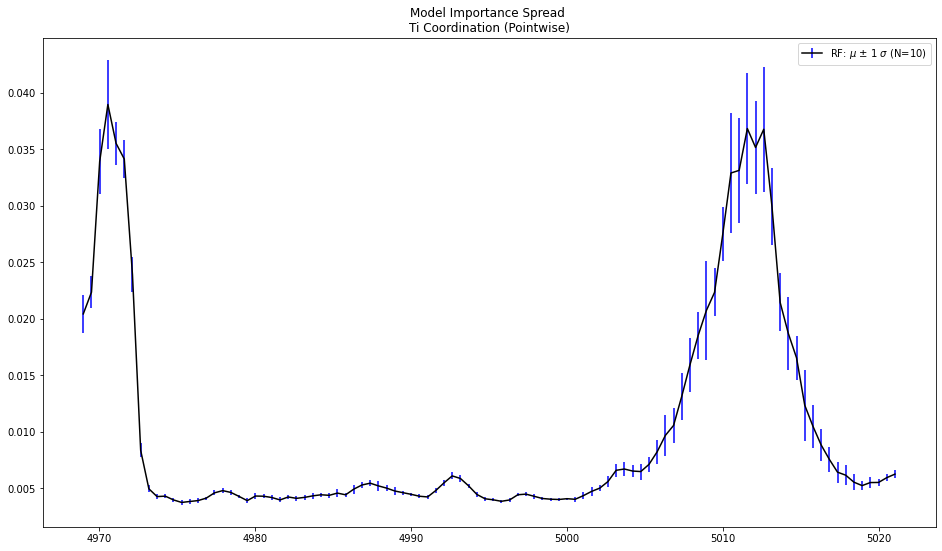

Done with Coordination for  ('Ti', 'O')




Cross Validation BADER: 100%|██████████████████████████████| 9/9 [43:28<00:00, 289.88s/it]


<Figure size 432x288 with 0 Axes>

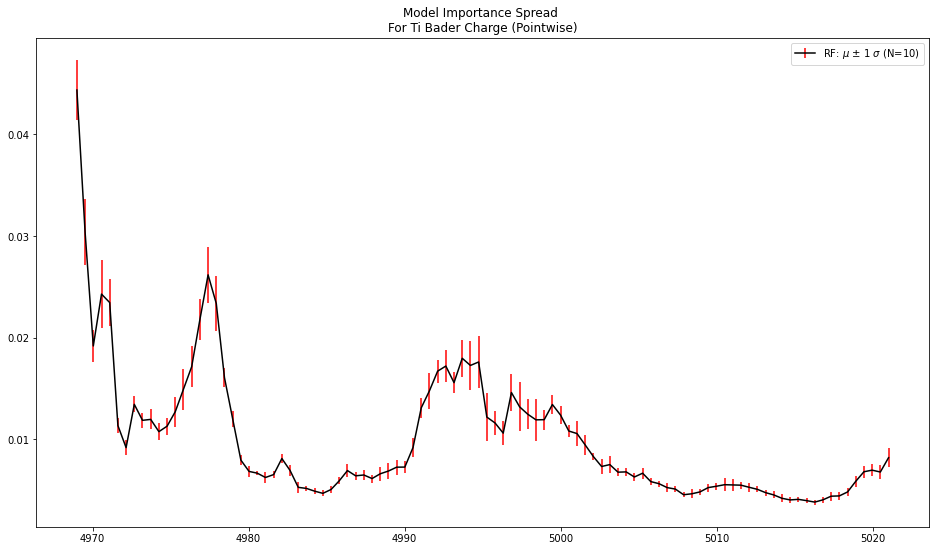

Done with Bader for  ('Ti', 'O')



Cross Validation MD: 100%|███████████████████████████████| 9/9 [1:12:11<00:00, 481.22s/it]


<Figure size 432x288 with 0 Axes>

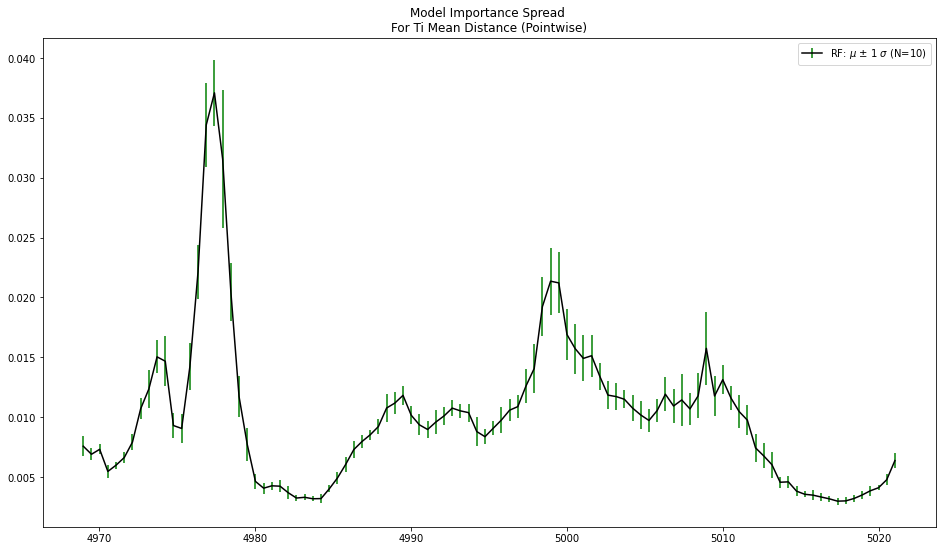

target_elements_groups:  12%|██▉                    | 1/8 [3:44:59<26:14:56, 13499.56s/it]

Done with mean distance



Cross Validation coord: 100%|████████████████████████████| 9/9 [1:52:47<00:00, 751.97s/it]


<Figure size 432x288 with 0 Axes>

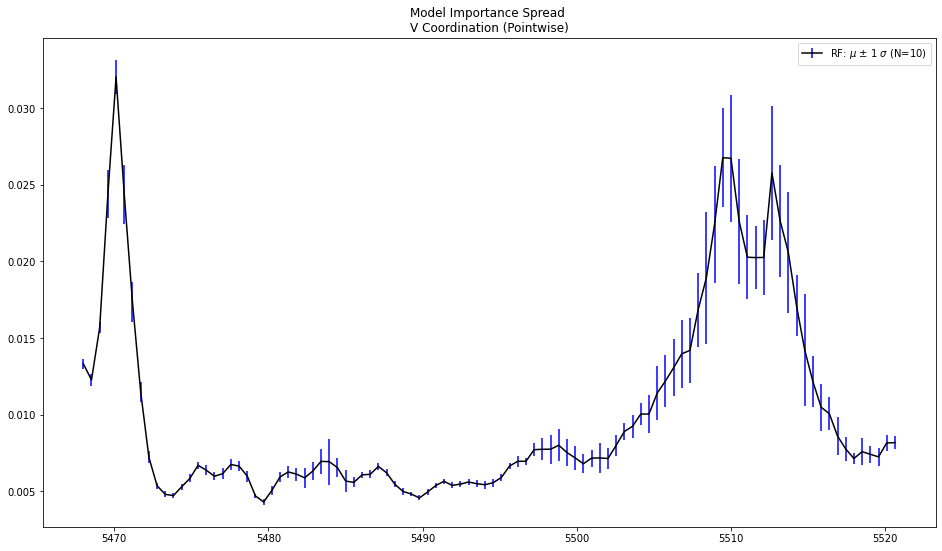

Done with Coordination for  ('V', 'O')



Cross Validation BADER: 100%|██████████████████████████████| 9/9 [58:31<00:00, 390.13s/it]


<Figure size 432x288 with 0 Axes>

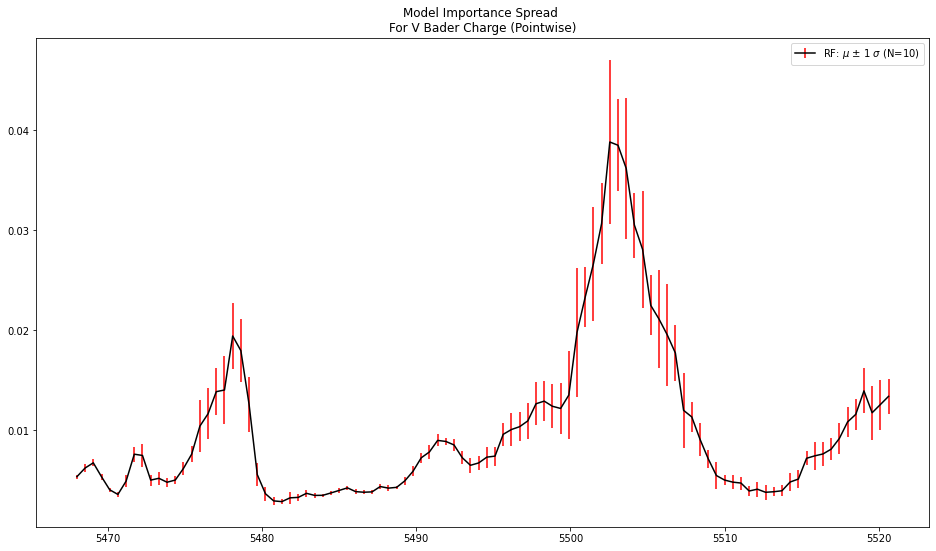

Done with Bader for  ('V', 'O')



Cross Validation MD: 100%|███████████████████████████████| 9/9 [1:55:16<00:00, 768.45s/it]


<Figure size 432x288 with 0 Axes>

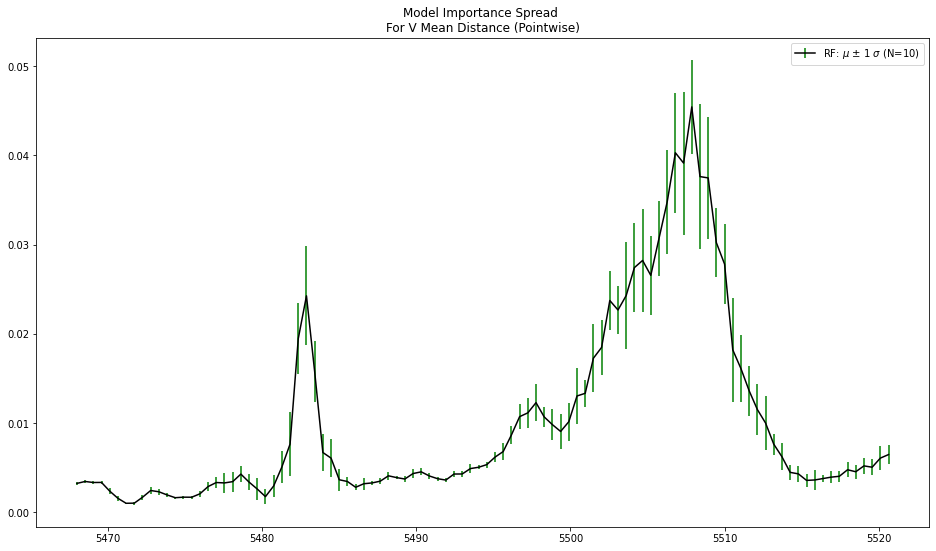

target_elements_groups:  25%|█████▊                 | 2/8 [9:02:15<25:16:02, 15160.41s/it]

Done with mean distance



Cross Validation coord: 100%|████████████████████████████| 9/9 [1:08:29<00:00, 456.56s/it]


<Figure size 432x288 with 0 Axes>

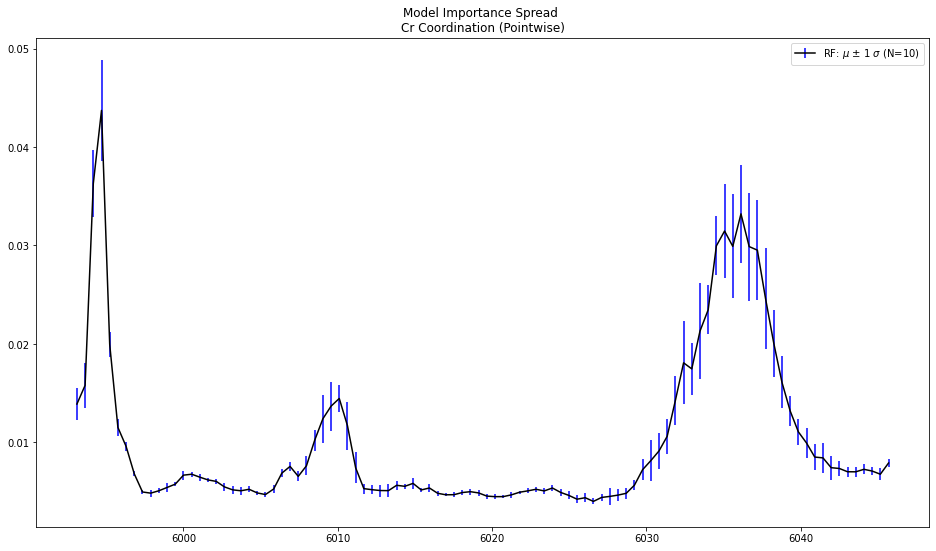

Done with Coordination for  ('Cr', 'O')



Cross Validation BADER: 100%|██████████████████████████████| 9/9 [33:15<00:00, 221.69s/it]


<Figure size 432x288 with 0 Axes>

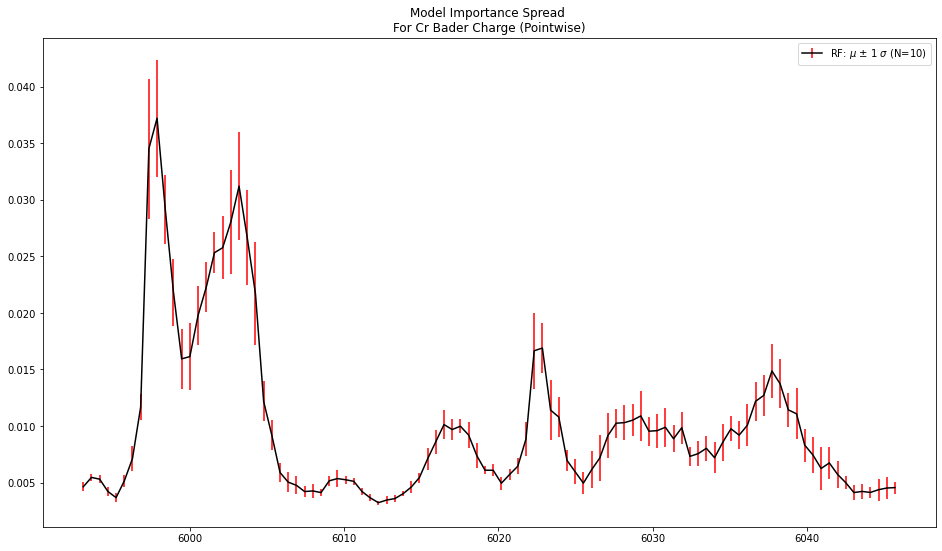

Done with Bader for  ('Cr', 'O')



Cross Validation MD: 100%|█████████████████████████████████| 9/9 [44:59<00:00, 299.91s/it]


<Figure size 432x288 with 0 Axes>

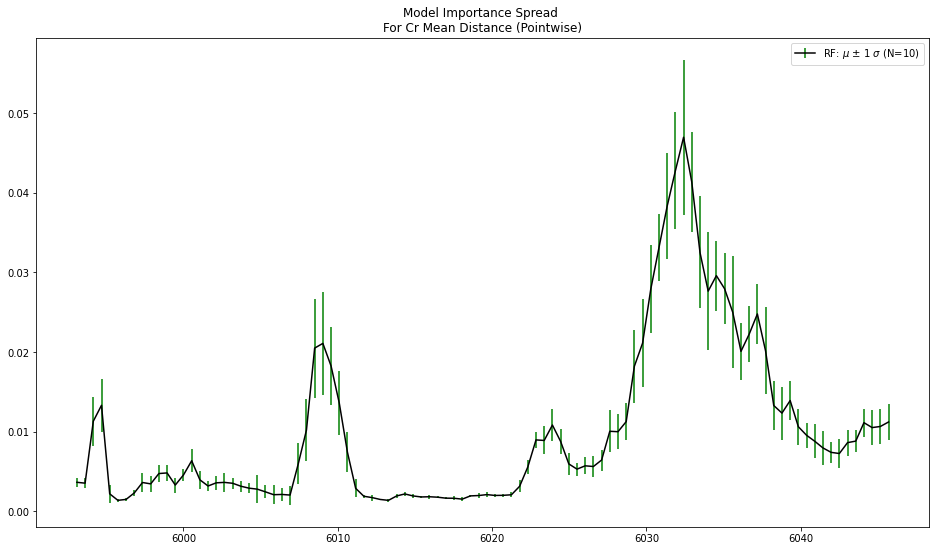

target_elements_groups:  38%|████████▎             | 3/8 [11:44:51<18:48:16, 13539.27s/it]

Done with mean distance



Cross Validation coord: 100%|███████████████████████████| 9/9 [3:23:54<00:00, 1359.40s/it]


<Figure size 432x288 with 0 Axes>

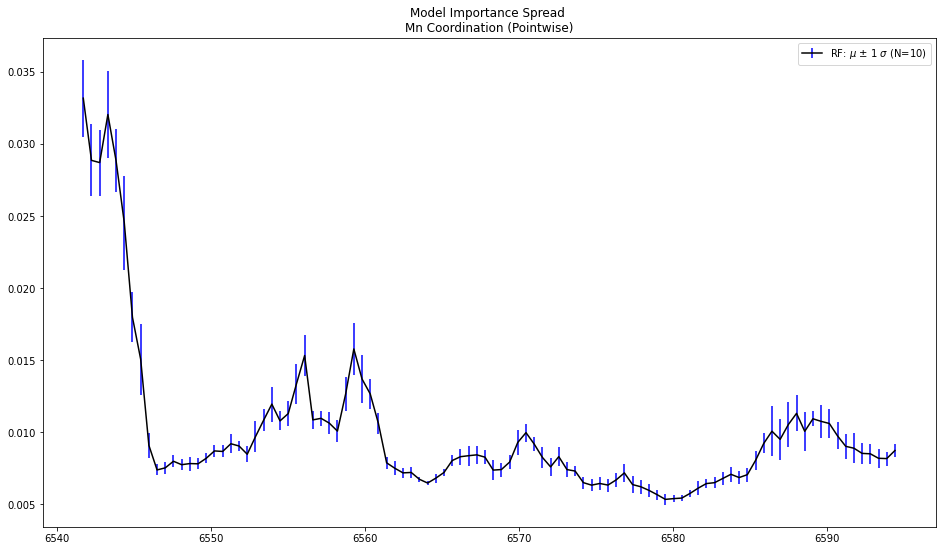

Done with Coordination for  ('Mn', 'O')



Cross Validation BADER: 100%|████████████████████████████| 9/9 [1:14:35<00:00, 497.29s/it]


<Figure size 432x288 with 0 Axes>

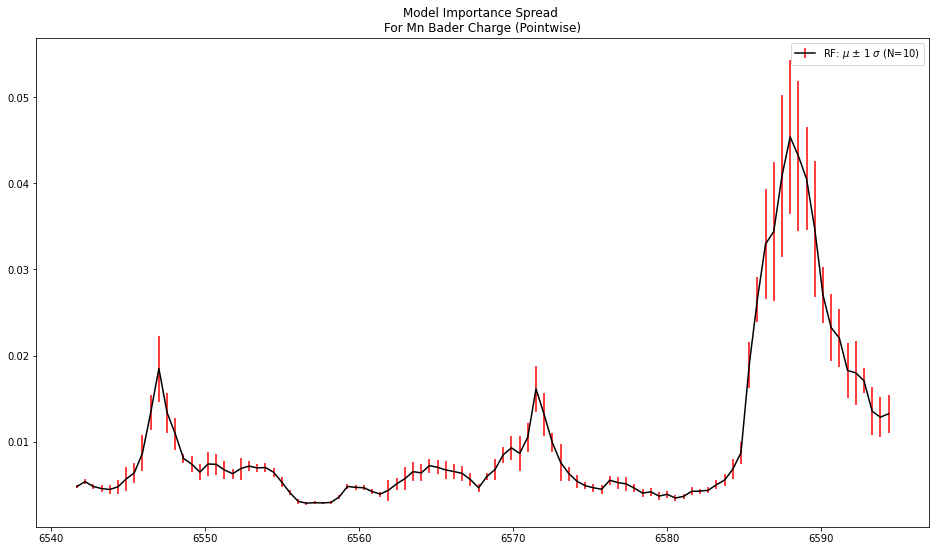

Done with Bader for  ('Mn', 'O')



Cross Validation MD: 100%|██████████████████████████████| 9/9 [2:34:05<00:00, 1027.28s/it]


<Figure size 432x288 with 0 Axes>

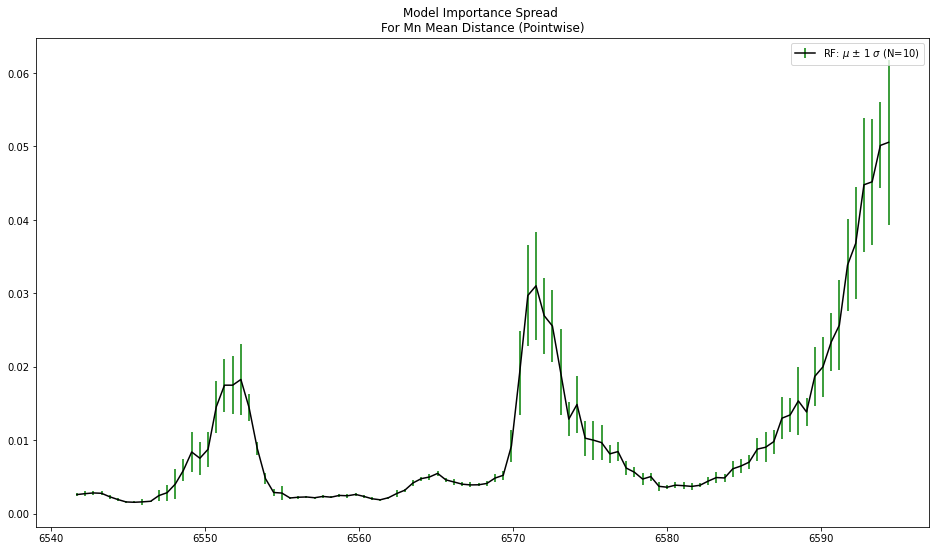

target_elements_groups:  50%|███████████           | 4/8 [19:44:26<20:07:20, 18110.02s/it]

Done with mean distance



Cross Validation coord: 100%|███████████████████████████| 9/9 [2:47:00<00:00, 1113.43s/it]


<Figure size 432x288 with 0 Axes>

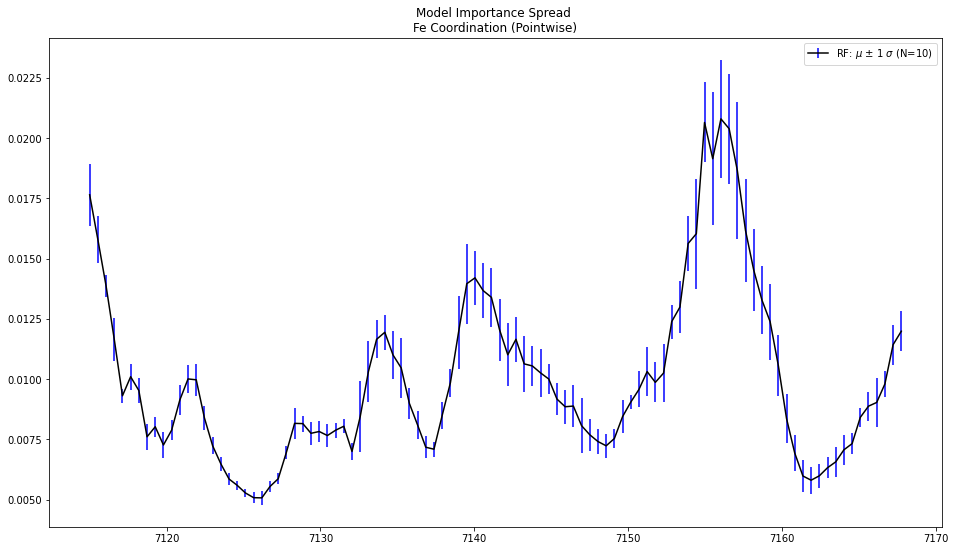

Done with Coordination for  ('Fe', 'O')



Cross Validation BADER: 100%|████████████████████████████| 9/9 [1:05:59<00:00, 439.95s/it]


<Figure size 432x288 with 0 Axes>

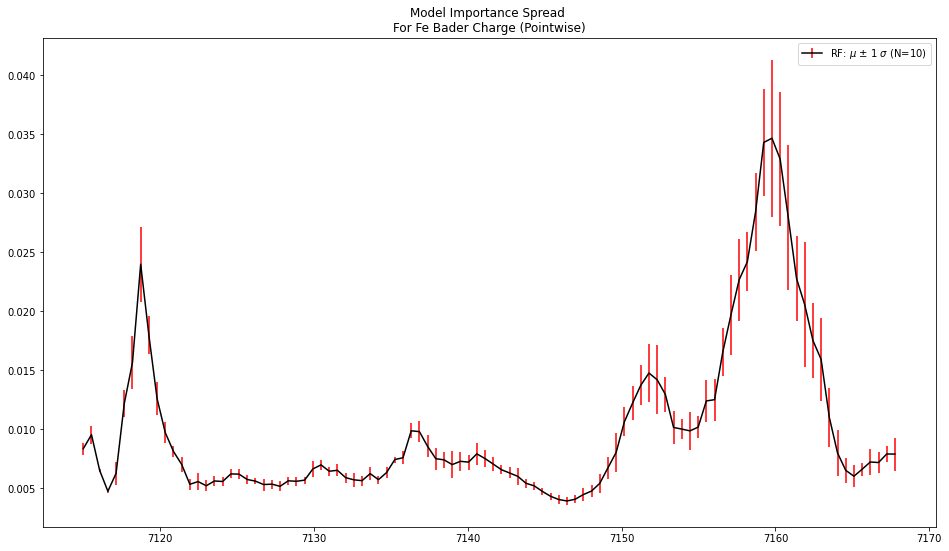

Done with Bader for  ('Fe', 'O')



Cross Validation MD: 100%|███████████████████████████████| 9/9 [1:52:25<00:00, 749.53s/it]


<Figure size 432x288 with 0 Axes>

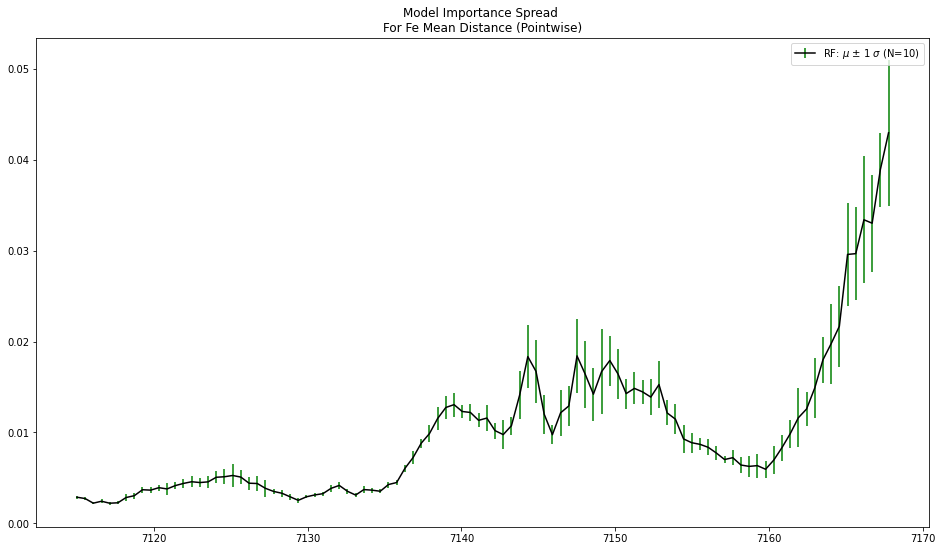

target_elements_groups:  62%|█████████████▊        | 5/8 [26:08:39<16:19:38, 19592.87s/it]

Done with mean distance



Cross Validation coord: 100%|████████████████████████████| 9/9 [1:32:46<00:00, 618.55s/it]


<Figure size 432x288 with 0 Axes>

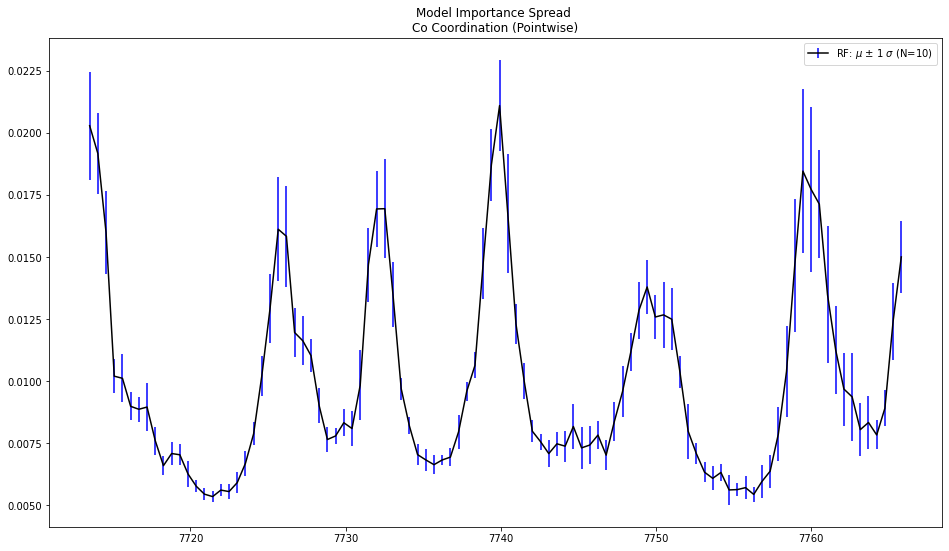

Done with Coordination for  ('Co', 'O')



Cross Validation BADER: 100%|██████████████████████████████| 9/9 [37:45<00:00, 251.73s/it]


<Figure size 432x288 with 0 Axes>

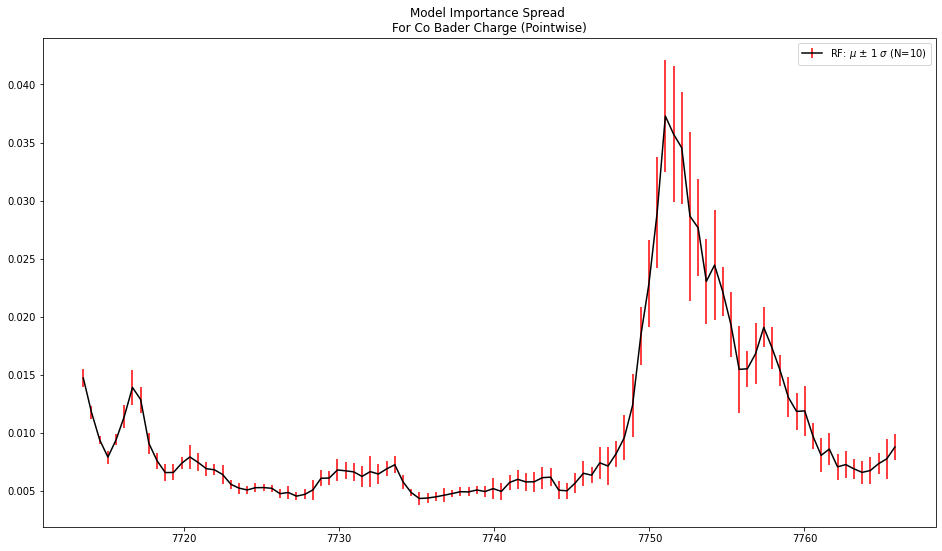

Done with Bader for  ('Co', 'O')



Cross Validation MD: 100%|███████████████████████████████| 9/9 [1:05:07<00:00, 434.13s/it]


<Figure size 432x288 with 0 Axes>

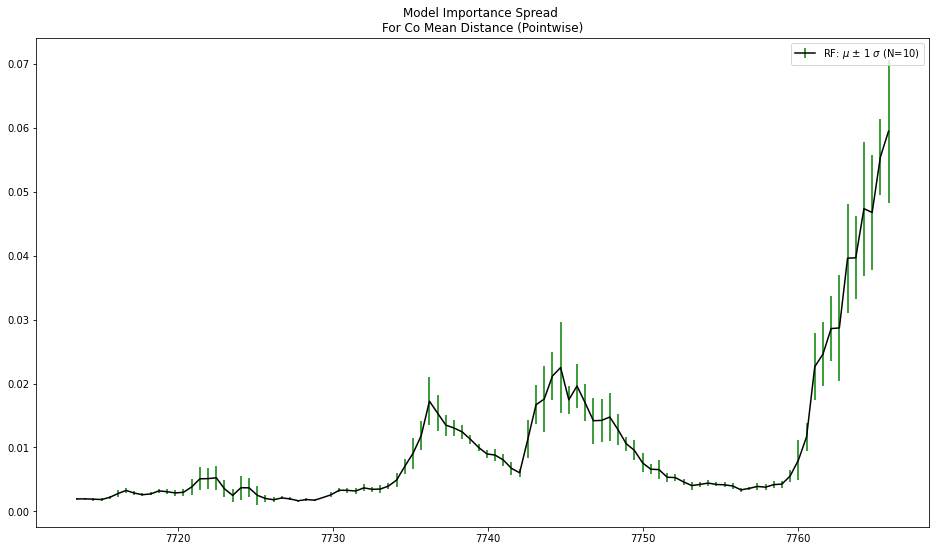

target_elements_groups:  75%|█████████████████▎     | 6/8 [29:45:57<9:47:32, 17626.15s/it]

Done with mean distance



Cross Validation coord: 100%|████████████████████████████| 9/9 [1:57:56<00:00, 786.32s/it]


<Figure size 432x288 with 0 Axes>

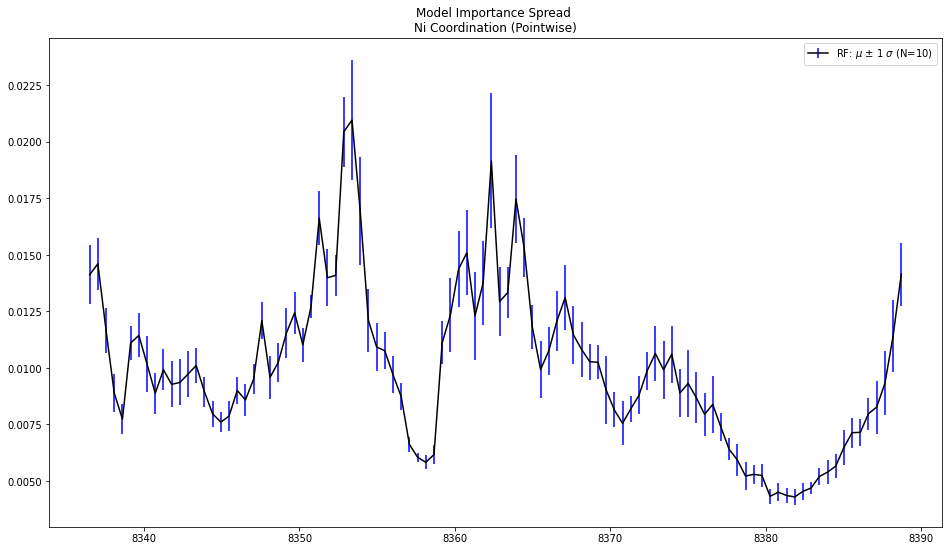

Done with Coordination for  ('Ni', 'O')



Cross Validation BADER: 100%|██████████████████████████████| 9/9 [43:29<00:00, 289.94s/it]


<Figure size 432x288 with 0 Axes>

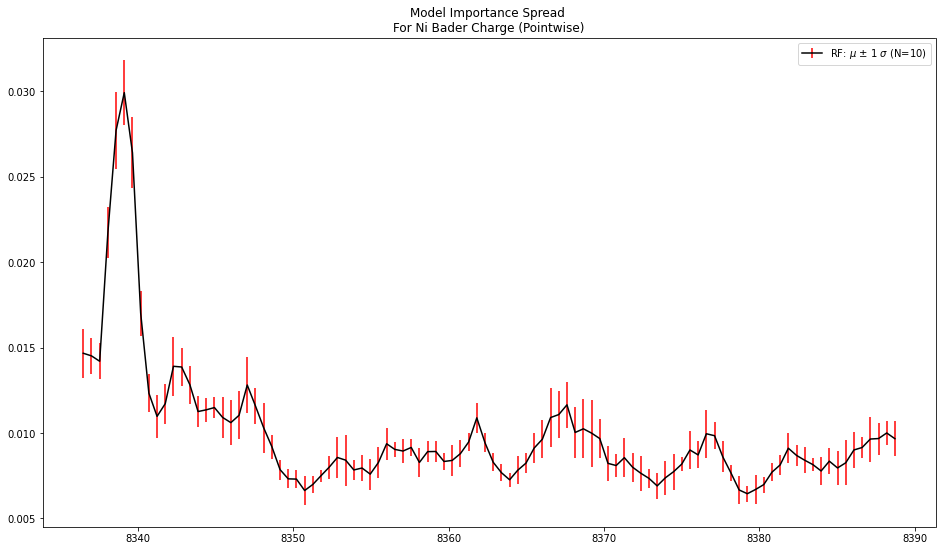

Done with Bader for  ('Ni', 'O')



Cross Validation MD: 100%|███████████████████████████████| 9/9 [1:08:33<00:00, 457.06s/it]


<Figure size 432x288 with 0 Axes>

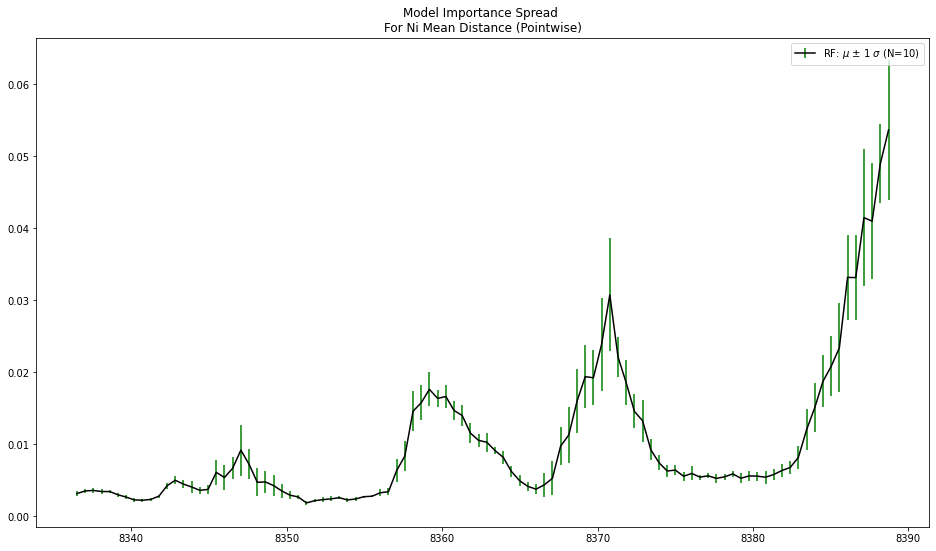

target_elements_groups:  88%|████████████████████▏  | 7/8 [34:01:26<4:42:17, 16937.27s/it]

Done with mean distance



Cross Validation coord: 100%|████████████████████████████| 9/9 [2:11:36<00:00, 877.37s/it]


<Figure size 432x288 with 0 Axes>

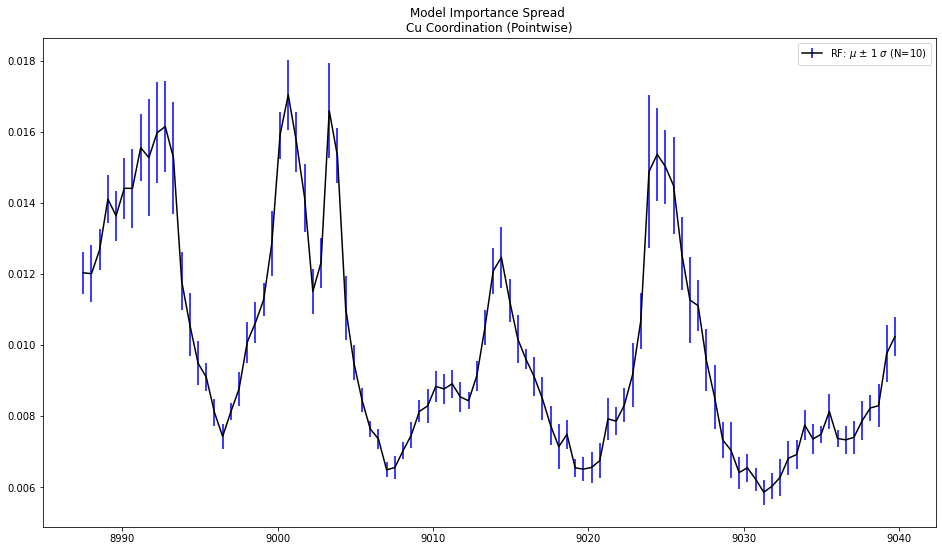

Done with Coordination for  ('Cu', 'O')



Cross Validation BADER: 100%|██████████████████████████████| 9/9 [45:52<00:00, 305.87s/it]


<Figure size 432x288 with 0 Axes>

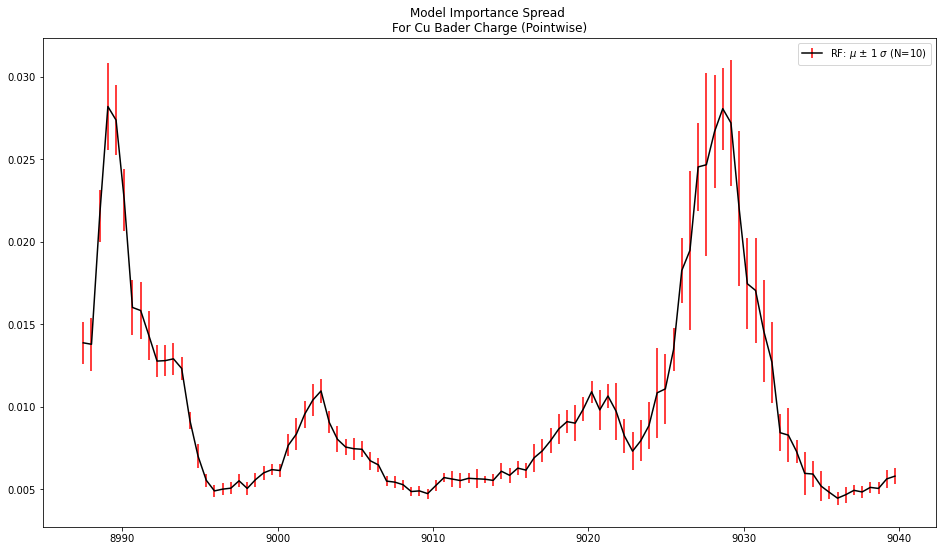

Done with Bader for  ('Cu', 'O')



Cross Validation MD: 100%|███████████████████████████████| 9/9 [1:13:56<00:00, 492.93s/it]


<Figure size 432x288 with 0 Axes>

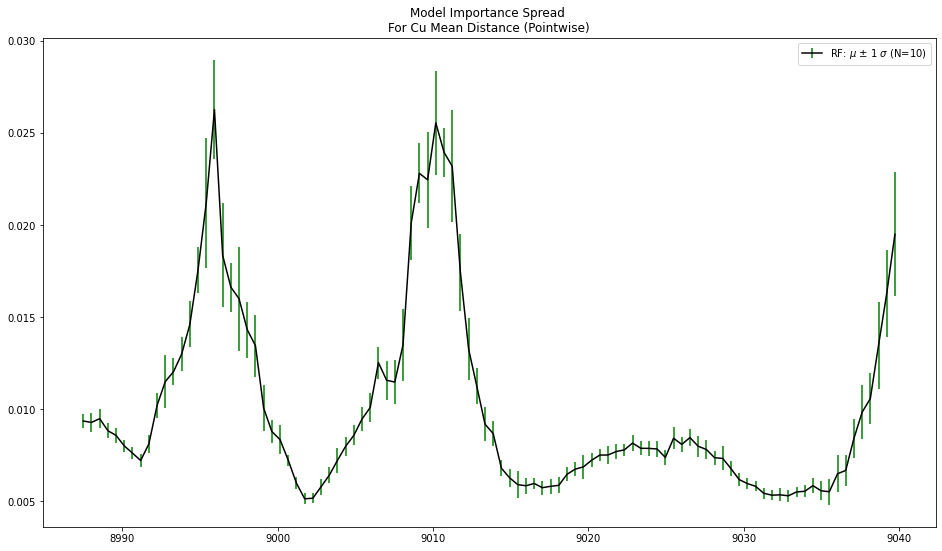

target_elements_groups: 100%|█████████████████████████| 8/8 [38:40:38<00:00, 17404.85s/it]

Done with mean distance


In [12]:
#N_ESTIMATORS = 300
#N_EPOCHS = 150
# RANK_REPEAT = 9

N_ESTIMATORS = 300
N_EPOCHS = 300
RANK_REPEAT = 9
VERBOSE = 0
pair = target_elements_groups[0]

pair = target_elements_groups[0]
for pair in tqdm(target_elements_groups, ncols=90, desc='target_elements_groups'):
    if not run:
        continue
    
    # Instantiate each random forest model
    
    forest_c = RandomForestClassifier(random_state=rseed,
                                      n_estimators=N_ESTIMATORS,
                                      max_depth =35, 
                                      max_features = 8, min_samples_leaf = 1,
                                      min_samples_split = 2,
                                      class_weight=None,
                                      n_jobs=4)


    forest_b = RandomForestRegressor(random_state=rseed,
                                     criterion='mse',max_depth=35,
                                     max_features=8, max_leaf_nodes=None,
                                     min_impurity_decrease=0.0, min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0, n_estimators=N_ESTIMATORS,
                                     n_jobs=4)
    
    forest_md = RandomForestRegressor(random_state=rseed,
                                      criterion='mse',max_depth=35,
                                      max_features=8, max_leaf_nodes=None,
                                      min_impurity_decrease=0.0, min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0, n_estimators=N_ESTIMATORS,
                                      n_jobs=4)

    # Instantiate each neural nets model
    # nn_c = KerasClassifier(build_fn=baseline_model_c, epochs=N_EPOCHS, batch_size=32, verbose=VERBOSE)
    
    # nn_b = Pipeline([('standardize', StandardScaler()),
    #                  ('estimator', KerasRegressor(build_fn=base_model_b, epochs=N_EPOCHS, batch_size=32, verbose=VERBOSE))])
    # nn_md = Pipeline([('standardize', StandardScaler()),
    #                   ('estimator', KerasRegressor(build_fn=base_model_md, epochs=N_EPOCHS, batch_size=32, verbose=VERBOSE))])

    nn_c = KerasClassifier(build_fn=cnn_model_c, epochs=N_EPOCHS, batch_size=32, verbose=VERBOSE)
    nn_b = KerasRegressor(build_fn=cnn_model_b, epochs=N_EPOCHS, batch_size=32, verbose=VERBOSE)
    nn_md = KerasRegressor(build_fn=cnn_model_md, epochs=N_EPOCHS, batch_size=32, verbose=VERBOSE)

    #############################################
    # COORDINATION
    #############################################
    
    xc_train = ttc_by_pair[pair]['train_x'] 
    yc_train = ttc_by_pair[pair]['train_y'] 
    #xc_train = x_augmentation(xc_train, delta=0.5)
    #yc_train = y_augmentation(yc_train, delta=0.00)

    if use_test:
        xc_valid = ttc_by_pair[pair]['test_x']
        yc_valid = ttc_by_pair[pair]['test_y'] 
    else:
        xc_valid = ttc_by_pair[pair]['valid_x'] 
        yc_valid = ttc_by_pair[pair]['valid_y']
        #xc_valid = x_augmentation(xc_valid, delta=0.5)
        #yc_valid = y_augmentation(yc_valid, delta=0.00)
            
    
    if run_coord:
        forest_c.fit(xc_train,yc_train)        
        nn_c.fit(xcnn(xc_train),ycnn(yc_train))

        ################## FEATURE RANKING VARIANCE INTERLUDE ######################

        cur_model_f1s = [[x[2]*100 for x in  precision_recall_matrix(forest_c.predict(xc_valid),yc_valid,[4,5,6])]]
        cur_model_accuracies = [forest_c.score(xc_valid,yc_valid)]
        cur_model_importances = [forest_c.feature_importances_] 

        nn_model_f1s = [[x[2]*100 for x in  precision_recall_matrix(nn_c.predict(xcnn(xc_valid))+4,yc_valid,[4,5,6])]]
        nn_model_accuracies = [nn_c.score(xcnn(xc_valid), ycnn(yc_valid))]
        
        for i in tqdm(range(RANK_REPEAT), ncols=90, desc='Cross Validation coord'):
            forest_c.random_state = rseed+i+1
            forest_c.fit(xc_train,yc_train)
            cur_model_importances.append(forest_c.feature_importances_)
            cur_model_accuracies.append(forest_c.score(xc_valid,yc_valid))
            cur_model_f1s.append([x[2]*100 for x in precision_recall_matrix(forest_c.predict(xc_valid),yc_valid,[4,5,6])])

            nn_c.fit(xcnn(xc_train),ycnn(yc_train))
            nn_model_accuracies.append(nn_c.score(xcnn(xc_valid),ycnn(yc_valid)))
            nn_model_f1s.append([x[2]*100 for x in precision_recall_matrix(nn_c.predict(xcnn(xc_valid))+4,yc_valid,[4,5,6])])

        importances_mean = np.mean(cur_model_importances,axis=0)
        coord_accuracies_mean = np.mean(cur_model_accuracies)
        coord_f1s_mean = np.mean(cur_model_f1s, axis=0)

        nn_coord_accuracies_mean = np.mean(nn_model_accuracies)
        nn_coord_f1s_mean = np.mean(nn_model_f1s, axis=0)

        if RANK_REPEAT:
            importances_std = np.std(cur_model_importances,axis=0)
            coord_accuracies_std = np.std(cur_model_accuracies)
            coord_f1s_std = np.std(cur_model_f1s,   axis=0)
            nn_coord_accuracies_std = np.std(nn_model_accuracies)
            nn_coord_f1s_std = np.std(nn_model_f1s,   axis=0)
        else:
            importances_std = np.zeros(len(cur_model_importances))
            coord_accuracies_std = np.zeros(len(cur_model_accuracies))
            coord_f1s_std = np.zeros(len(cur_model_f1s))
            nn_coord_accuracies_std = np.zeros(len(nn_model_accuracies))
            nn_coord_f1s_std = np.zeros(len(nn_model_f1s))


        means_by_pair[str(pair)+'-coord'] = importances_mean

        plt.clf()
        plt.figure(figsize=(16,9))
        plt.errorbar(x_domains[pair],importances_mean,yerr= importances_std,
                     label='RF: $\mu$ $\pm$ 1 $\sigma$ (N={})'.format(1+RANK_REPEAT),
                     color='black',ecolor='blue')
        plt.title("Model Importance Spread \n{} Coordination (Pointwise)".format(pair[0]))
        plt.legend()
        plt.savefig(figure_write_folder+'/{}_{}_all_coord_mean_importances.pdf'.format(pair[0],norm_str),
                    format='pdf',dpi=300,transparent=True,bbox_inches='tight')
        plt.show()

        # Store the last model trained for later 
        # use in comparing against polynomial models.
        models_by_pair[str(pair)+'-Coord'] = forest_c
        models_by_pair_nn[str(pair)+'-Coord'] = nn_c

        print("Done with Coordination for ",pair)
        
        class_makeup = Counter(yc_valid)
        mode_guess_score = max(class_makeup.values())/sum(class_makeup.values())
    #############################################
    # BADER
    #############################################
    
    xb_train =  ttb_by_pair[pair]['train_x']
    yb_train =  ttb_by_pair[pair]['train_y']
    #xb_train = x_augmentation(xb_train, delta=0.5)
    #yb_train = y_augmentation(yb_train, delta=0.03)
    
    if use_test:
        xb_valid = ttb_by_pair[pair]['test_x']
        yb_valid = ttb_by_pair[pair]['test_y']
    else:
        xb_valid = ttb_by_pair[pair]['valid_x']
        yb_valid = ttb_by_pair[pair]['valid_y']
        #xb_valid = x_augmentation(xb_valid, delta=0.5)
        #yb_valid = y_augmentation(yb_valid, delta=0.03)
 
    
    if run_bader:
        forest_b.fit(xb_train,yb_train)    
        nn_b.fit(xcnn(xb_train), yb_train)

        cur_model_importances = [forest_b.feature_importances_] 
        cur_model_accuracies = [r2_score(yb_valid,forest_b.predict(xb_valid))] # R-Squared
        cur_model_maes = [np.mean(np.abs(forest_b.predict(xb_valid) - yb_valid))]

        nn_model_accuracies = [r2_score(yb_valid,nn_b.predict(xcnn(xb_valid)))] # R-Squared
        nn_model_maes = [np.mean(np.abs(nn_b.predict(xcnn(xb_valid)) - yb_valid))]

        for i in tqdm(range(RANK_REPEAT), ncols=90, desc='Cross Validation BADER'):
            forest_b.random_state = rseed+i+1
            forest_b.fit(xb_train,yb_train)
            cur_model_importances.append(forest_b.feature_importances_)
            cur_model_accuracies.append(r2_score(forest_b.predict(xb_valid), yb_valid))
            cur_model_maes.append(np.mean(np.abs(forest_b.predict(xb_valid) - yb_valid)))

            nn_b.fit(xcnn(xb_train),yb_train)
            nn_model_accuracies.append(r2_score(nn_b.predict(xcnn(xb_valid)),yb_valid))
            nn_model_maes.append(np.mean(np.abs(nn_b.predict(xcnn(xb_valid)) - yb_valid)))

        importances_mean = np.mean(cur_model_importances,axis=0)
        bader_accuracies_mean  = np.mean(cur_model_accuracies)
        bader_maes_mean = np.mean(cur_model_maes)

        nn_bader_accuracies_mean  = np.mean(nn_model_accuracies)
        nn_bader_maes_mean = np.mean(nn_model_maes)

        if RANK_REPEAT:
            importances_std  = np.std(cur_model_importances,axis=0)
            bader_accuracies_std   = np.std(cur_model_accuracies)
            bader_maes_std = np.std(cur_model_maes)
            nn_bader_accuracies_std   = np.std(nn_model_accuracies)
            nn_bader_maes_std = np.std(nn_model_maes)
        else:
            importances_std = np.zeros(len(cur_model_importances))
            bader_accuracies_std = np.zeros(len(cur_model_accuracies))
            bader_maes_std = np.zeros(len(cur_model_maes))
            nn_bader_accuracies_std = np.zeros(len(nn_model_accuracies))
            nn_bader_maes_std = np.zeros(len(nn_model_maes))


        accuracies[str(pair)+'-Bader'] = bader_accuracies_mean
        deviations[str(pair)+'-Bader'] = bader_accuracies_std
        means_by_pair[str(pair)+'-Bader'] = importances_mean

        accuracies_nn[str(pair)+'-Bader'] = nn_bader_accuracies_mean
        deviations_nn[str(pair)+'-Bader'] = nn_bader_accuracies_std

        plt.clf()
        plt.figure(figsize=(16,9))
        plt.errorbar(x_domains[pair],importances_mean, yerr=importances_std,
                     label='RF: $\mu$ $\pm$ 1 $\sigma$ (N={})'.format(1+RANK_REPEAT),
                     color='black',ecolor='red')
        plt.title("Model Importance Spread \nFor {} Bader Charge (Pointwise)".format(pair[0]))
        plt.legend()
        plt.savefig(figure_write_folder+'/{}_{}_all_bader_mean_importances.pdf'.format(pair[0],norm_str),format='pdf',dpi=300,transparent=True,bbox_inches='tight')

        plt.show()

        # Store the last model trained for later 
        # use in comparing against polynomial models.
        models_by_pair[str(pair)+'-Bader'] = forest_b
        models_by_pair_nn[str(pair)+'-Bader'] = nn_b

        bader_perf_by_pair[pair[0]+'-guesses'] = forest_b.predict(xb_valid)
        bader_perf_by_pair[pair[0]+'-labels'] = yb_valid

        bader_perf_by_pair_nn[pair[0]+'-guesses'] = nn_b.predict(xcnn(xb_valid))
        bader_perf_by_pair_nn[pair[0]+'-labels'] = yb_valid

        print("Done with Bader for ",pair)

    ##############################
    #   MD PART
    ##############################

    xmd_train = np.array(ttmd_by_pair[pair]['train_x'])
    ymd_train = np.array(ttmd_by_pair[pair]['train_y'])
    #xmd_train = x_augmentation(xmd_train, delta=0.5)
    #ymd_train = y_augmentation(ymd_train, delta=0.03)
    
    if use_test:
        xmd_valid = np.array(ttmd_by_pair[pair]['test_x'])
        ymd_valid = np.array(ttmd_by_pair[pair]['test_y'])
    else:
        xmd_valid = np.array(ttmd_by_pair[pair]['valid_x'])
        ymd_valid = np.array(ttmd_by_pair[pair]['valid_y'])
        #xmd_valid = x_augmentation(xmd_valid, delta=0.5)
        #ymd_valid = y_augmentation(ymd_valid, delta=0.03)
    
    md_perf_by_pair[pair[0]+'-labels'] = ymd_valid
    
    if run_md:
        forest_md.fit(xmd_train,ymd_train)    
        nn_md.fit(xcnn(xmd_train), ymd_train)

        cur_model_importances = [forest_md.feature_importances_] 
        cur_model_accuracies = [r2_score(ymd_valid,forest_md.predict(xmd_valid))] # R-squared
        cur_model_maes = [np.mean(np.abs(forest_md.predict(xmd_valid) - ymd_valid))]

        nn_model_accuracies = [r2_score(ymd_valid,nn_md.predict(xcnn(xmd_valid)))] # R-squared
        nn_model_maes = [np.mean(np.abs(nn_md.predict(xcnn(xmd_valid)) - ymd_valid))]

        for i in tqdm(range(RANK_REPEAT), ncols=90, desc='Cross Validation MD'):
            forest_md.random_state = rseed+i+1
            forest_md.fit(xmd_train,ymd_train)
            cur_model_importances.append(forest_md.feature_importances_)
            cur_model_accuracies.append(r2_score(ymd_valid,forest_md.predict(xmd_valid)))
            cur_model_maes.append(np.mean(np.abs(forest_md.predict(xmd_valid) - ymd_valid)))

            nn_md.fit(xcnn(xmd_train),ymd_train)
            nn_model_accuracies.append(r2_score(ymd_valid,nn_md.predict(xcnn(xmd_valid))))
            nn_model_maes.append(np.mean(np.abs(nn_md.predict(xcnn(xmd_valid)) - ymd_valid)))

        importances_mean = np.mean(cur_model_importances,axis=0)
        md_accuracies_mean  = np.mean(cur_model_accuracies,axis=0)
        md_maes_mean = np.mean(cur_model_maes,axis=0)

        nn_md_accuracies_mean  = np.mean(nn_model_accuracies)
        nn_md_maes_mean = np.mean(nn_model_maes)

        if RANK_REPEAT:
            importances_std  = np.std(cur_model_importances,axis=0)
            md_accuracies_std   = np.std(cur_model_accuracies,axis=0)
            md_maes_std = np.std(cur_model_maes,axis=0)
            nn_md_accuracies_std   = np.std(nn_model_accuracies)
            nn_md_maes_std = np.std(nn_model_maes)
        else:
            importances_std  = np.zeros(len(cur_model_importances),axis=0)
            md_accuracies_std   = np.zeros(len(cur_model_accuracies),axis=0)
            md_maes_std = np.zeros(len(cur_model_maes),axis=0)
            nn_md_accuracies_std = np.zeros(len(nn_model_accuracies))
            nn_md_maes_std = np.zeros(len(nn_model_maes))

        means_by_pair[str(pair)+'-md'] = importances_mean

        plt.clf()
        plt.figure(figsize=(16,9))
        plt.errorbar(x_domains[pair],importances_mean,yerr= importances_std,
                     label='RF: $\mu$ $\pm$ 1 $\sigma$ (N={})'.format(1+RANK_REPEAT),
                     color='black',ecolor='green')
        plt.title("Model Importance Spread \nFor {} Mean Distance (Pointwise)".format(pair[0]))
        plt.legend()
        plt.savefig(figure_write_folder+'/{}_{}_all_md_mean_importances.pdf'.format(pair[0],norm_str),format='pdf',dpi=300,transparent=True,bbox_inches='tight')
        plt.show()

        models_by_pair[str(pair)+'-Mean'] = forest_md
        models_by_pair_nn[str(pair)+'-Mean'] = nn_md

        # Used in constructing parity plots later

        md_perf_by_pair[pair[0]+'-guesses'] = forest_md.predict(xmd_valid)    
        md_perf_by_pair_nn[pair[0]+'-guesses'] = nn_md.predict(xcnn(xmd_valid))    
    
        print("Done with mean distance")
        
    if not (run_bader and run_md and run_coord):
        continue
    
       
    if RANK_REPEAT:
        #AVERAGES
        accuracies[str(pair)+'-Coord'] = np.round(coord_accuracies_mean*100,4)
        accuracies[str(pair)+'-Coord-F1'] = np.round(coord_f1s_mean,2)
        accuracies[str(pair)+'-GuessMode'] = np.round(mode_guess_score*100,2)
        
        accuracies[str(pair)+'-Bader'] = np.round(bader_accuracies_mean*100,4)
        accuracies[str(pair)+'-Bader-MAE'] = np.round(bader_maes_mean,2)
        
        accuracies[str(pair)+'-MeanDist'] = np.round(md_accuracies_mean*100,4)
        accuracies[str(pair)+'-MeanDist-MAE'] = np.round(md_maes_mean,3)


        accuracies_nn[str(pair)+'-Coord'] = np.round(nn_coord_accuracies_mean*100,4)
        accuracies_nn[str(pair)+'-Coord-F1'] = np.round(nn_coord_f1s_mean,2)
        accuracies_nn[str(pair)+'-GuessMode'] = np.round(mode_guess_score*100,2)
        
        accuracies_nn[str(pair)+'-Bader'] = np.round(nn_bader_accuracies_mean*100,4)
        accuracies_nn[str(pair)+'-Bader-MAE'] = np.round(nn_bader_maes_mean,2)
        
        accuracies_nn[str(pair)+'-MeanDist'] = np.round(nn_md_accuracies_mean*100,4)
        accuracies_nn[str(pair)+'-MeanDist-MAE'] = np.round(nn_md_maes_mean,3)
        
        # DEVIATIONS
        deviations[str(pair)+'-Coord'] = np.round(coord_accuracies_std*100,4)
        deviations[str(pair)+'-Coord-F1'] = np.round(coord_f1s_std,4)
        
        deviations[str(pair)+'-Bader'] = np.round(bader_accuracies_std*100,4)
        deviations[str(pair)+'-Bader-MAE'] = np.round(bader_maes_std,4)
        
        deviations[str(pair)+'-MeanDist'] = np.round(md_accuracies_std*100,4)
        deviations[str(pair)+'-MeanDist-MAE'] = np.round(md_maes_std,4)                    

        deviations_nn[str(pair)+'-Coord'] = np.round(nn_coord_accuracies_std*100,4)
        deviations_nn[str(pair)+'-Coord-F1'] = np.round(nn_coord_f1s_std,4)
        
        deviations_nn[str(pair)+'-Bader'] = np.round(nn_bader_accuracies_std*100,4)
        deviations_nn[str(pair)+'-Bader-MAE'] = np.round(nn_bader_maes_std,4)
        
        deviations_nn[str(pair)+'-MeanDist'] = np.round(nn_md_accuracies_std*100,4)
        deviations_nn[str(pair)+'-MeanDist-MAE'] = np.round(nn_md_maes_std,4)                    
    else:
        accuracies[str(pair)+'-Coord'] = np.round(forest_c.score(xc_valid,yc_valid),2)
        accuracies[str(pair)+'-Coord-F1'] = np.round(avg_f1_score(guesses=guesses,labels=yc_valid),2)
        accuracies[str(pair)+'-GuessMode'] = np.round(mode_guess_score,2)
        
        accuracies[str(pair)+'-Bader'] = np.round(forest_b.score(xb_valid,yb_valid),2)
        accuracies[str(pair)+'-Bader-MAE'] = np.round(np.abs(forest_b.predict(xb_valid)-yb_valid).mean(),2)
        
        accuracies[str(pair)+'-MeanDist'] = np.round(forest_md.score(xmd_valid,ymd_valid),2)
        accuracies[str(pair)+'-MeanDist-MAE'] = np.round(np.abs(forest_md.predict(xmd_valid)-ymd_valid).mean(),2)
                         
        deviations[str(pair)+'-Coord'] = 0
        deviations[str(pair)+'-Coord-F1'] = 0
        deviations[str(pair)+'-GuessMode'] =0
        
        deviations[str(pair)+'-Bader'] = 0
        deviations[str(pair)+'-Bader-MAE'] = 0
        
        deviations[str(pair)+'-MeanDist'] =0
        deviations[str(pair)+'-MeanDist-MAE'] = 0
                                  
    
    all_data_values.append([pair[0],
                            accuracies[str(pair)+'-Coord'],
                            deviations[str(pair)+'-Coord'],
                            accuracies[str(pair)+'-Coord-F1'],
                            deviations[str(pair)+'-Coord-F1'],
                            accuracies[str(pair)+'-GuessMode'],
                            accuracies[str(pair)+'-Bader'],
                            deviations[str(pair)+'-Bader'],
                            accuracies[str(pair)+'-Bader-MAE'],
                            deviations[str(pair)+'-Bader-MAE'],
                            accuracies[str(pair)+'-MeanDist'],
                            deviations[str(pair)+'-MeanDist'],
                            accuracies[str(pair)+'-MeanDist-MAE'],
                            deviations[str(pair)+'-MeanDist-MAE']]
                          )
    all_data_values_nn.append([pair[0],
                            accuracies_nn[str(pair)+'-Coord'],
                            deviations_nn[str(pair)+'-Coord'],
                            accuracies_nn[str(pair)+'-Coord-F1'],
                            deviations_nn[str(pair)+'-Coord-F1'],
                            accuracies_nn[str(pair)+'-GuessMode'],
                            accuracies_nn[str(pair)+'-Bader'],
                            deviations_nn[str(pair)+'-Bader'],
                            accuracies_nn[str(pair)+'-Bader-MAE'],
                            deviations_nn[str(pair)+'-Bader-MAE'],
                            accuracies_nn[str(pair)+'-MeanDist'],
                            deviations_nn[str(pair)+'-MeanDist'],
                            accuracies_nn[str(pair)+'-MeanDist-MAE'],
                            deviations_nn[str(pair)+'-MeanDist-MAE']]
                          )
        

# Generate Performance Table

In [13]:
headers=['Material', 
         'Coord Baseline', 
         'Coord Acc.',
         'Coord F1 (4)','Coord F1 (5)','Coord F1 (6)',
         'Bader $R^2$', 
         'Bader MAE', 
         'Mean NN $R^2$',
         'Mean NN-MAE',]

### Random Forestmodel
f = open(figure_write_folder+'/pointwise_table_{}.csv'.format(norm_str),'w')
print(str(headers).strip('[').strip(']').replace("'",""))
f.write(str(headers).strip('[').strip(']').replace("'","")+'\n')
avgs = [0 for _ in range(len(headers))]

for pair in target_elements_groups:
    i=1
    
    elt = pair[0]
    
    the_str = elt+','
    
    the_str += "%.2f" %accuracies[str(pair)+'-GuessMode'] +','
    avgs[i] += accuracies[str(pair)+'-GuessMode']; i+=1;
    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord'] +' $\pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord']  +','
    avgs[i] += accuracies[str(pair)+'-Coord']; i+=1;
    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord-F1'][0] + ' $ \pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord-F1'][0] + ', '
    avgs[i] += accuracies[str(pair)+'-Coord-F1'][0]; i+=1;

    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord-F1'][1] + ' $ \pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord-F1'][1] + ', '
    avgs[i] += accuracies[str(pair)+'-Coord-F1'][1]; i+=1;
    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord-F1'][2] + ' $ \pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord-F1'][2] + ', '
    avgs[i] += accuracies[str(pair)+'-Coord-F1'][2]; i+=1;

    
    the_str += "%.2f" %accuracies[str(pair)+'-Bader'] +' $\pm$'
    the_str += "%.2f" %deviations[str(pair)+'-Bader'] +','
    avgs[i] += accuracies[str(pair)+'-Bader']; i+=1;

    
    the_str += "%.3f" %accuracies[str(pair)+'-Bader-MAE'] +' $\pm$'
    the_str += "%.3f" %deviations[str(pair)+'-Bader-MAE'] +' , '
    avgs[i] += accuracies[str(pair)+'-Bader-MAE']; i+=1;


    the_str += "%.2f" %accuracies[str(pair)+'-MeanDist'] +' $\pm$'
    the_str += "%.2f" %deviations[str(pair)+'-MeanDist'] +','
    avgs[i] += accuracies[str(pair)+'-MeanDist']; i+=1;

    
    the_str += "%.3f" %accuracies[str(pair)+'-MeanDist-MAE'] +' $\pm$'
    the_str += "%.3f" %deviations[str(pair)+'-MeanDist-MAE']
    avgs[i] += accuracies[str(pair)+'-MeanDist-MAE']; i+=1;

    f.write(the_str+'\n')

avgs = list(np.round(np.array(avgs)/8,2))
avgs[0]='Avgs.'
f.write(str(avgs).strip('[').strip(']'))
f.close()

### Neural Networks model
f = open(figure_write_folder+'/pointwise_table_{}_nn.csv'.format(norm_str),'w')
print(str(headers).strip('[').strip(']').replace("'",""))
f.write(str(headers).strip('[').strip(']').replace("'","")+'\n')
avgs = [0 for _ in range(len(headers))]

for pair in target_elements_groups:
    i=1
    
    elt = pair[0]
    
    the_str = elt+','
    
    the_str += "%.2f" %accuracies_nn[str(pair)+'-GuessMode'] +','
    avgs[i] += accuracies_nn[str(pair)+'-GuessMode']; i+=1;
    
    the_str += "%.2f" %accuracies_nn[str(pair)+'-Coord'] +' $\pm$ '
    the_str += "%.2f" %deviations_nn[str(pair)+'-Coord']  +','
    avgs[i] += accuracies_nn[str(pair)+'-Coord']; i+=1;
    
    the_str += "%.2f" %accuracies_nn[str(pair)+'-Coord-F1'][0] + ' $ \pm$ '
    the_str += "%.2f" %deviations_nn[str(pair)+'-Coord-F1'][0] + ', '
    avgs[i] += accuracies_nn[str(pair)+'-Coord-F1'][0]; i+=1;

    
    the_str += "%.2f" %accuracies_nn[str(pair)+'-Coord-F1'][1] + ' $ \pm$ '
    the_str += "%.2f" %deviations_nn[str(pair)+'-Coord-F1'][1] + ', '
    avgs[i] += accuracies_nn[str(pair)+'-Coord-F1'][1]; i+=1;
    
    the_str += "%.2f" %accuracies_nn[str(pair)+'-Coord-F1'][2] + ' $ \pm$ '
    the_str += "%.2f" %deviations_nn[str(pair)+'-Coord-F1'][2] + ', '
    avgs[i] += accuracies_nn[str(pair)+'-Coord-F1'][2]; i+=1;

    
    the_str += "%.2f" %accuracies_nn[str(pair)+'-Bader'] +' $\pm$'
    the_str += "%.2f" %deviations_nn[str(pair)+'-Bader'] +','
    avgs[i] += accuracies_nn[str(pair)+'-Bader']; i+=1;

    
    the_str += "%.3f" %accuracies_nn[str(pair)+'-Bader-MAE'] +' $\pm$'
    the_str += "%.3f" %deviations_nn[str(pair)+'-Bader-MAE'] +' , '
    avgs[i] += accuracies_nn[str(pair)+'-Bader-MAE']; i+=1;


    the_str += "%.2f" %accuracies_nn[str(pair)+'-MeanDist'] +' $\pm$'
    the_str += "%.2f" %deviations_nn[str(pair)+'-MeanDist'] +','
    avgs[i] += accuracies_nn[str(pair)+'-MeanDist']; i+=1;

    
    the_str += "%.3f" %accuracies_nn[str(pair)+'-MeanDist-MAE'] +' $\pm$'
    the_str += "%.3f" %deviations_nn[str(pair)+'-MeanDist-MAE']
    avgs[i] += accuracies_nn[str(pair)+'-MeanDist-MAE']; i+=1;

    f.write(the_str+'\n')

avgs = list(np.round(np.array(avgs)/8,2))
avgs[0]='Avgs.'
f.write(str(avgs).strip('[').strip(']'))
f.close()

Material, Coord Baseline, Coord Acc., Coord F1 (4), Coord F1 (5), Coord F1 (6), Bader $R^2$, Bader MAE, Mean NN $R^2$, Mean NN-MAE
Material, Coord Baseline, Coord Acc., Coord F1 (4), Coord F1 (5), Coord F1 (6), Bader $R^2$, Bader MAE, Mean NN $R^2$, Mean NN-MAE


## Size of training data

In [14]:
data_size = []
for pair in tqdm(target_elements_groups, ncols=90, desc='target_elements_groups'):
    #############################################
    # COORDINATION
    #############################################
    yc_train = ttc_by_pair[pair]['train_y'] 
    #yc_train = y_augmentation(yc_train, delta=0.00)

    #############################################
    # BADER
    #############################################
    yb_train =  ttb_by_pair[pair]['train_y']
    #yb_train = y_augmentation(yb_train, delta=0.02)
    
    ##############################
    #   MD PART
    ##############################
    ymd_train = np.array(ttmd_by_pair[pair]['train_y'])
    #ymd_train = y_augmentation(ymd_train, delta=0.02)
    
    data_size.append([len(yc_train), len(yb_train), len(ymd_train)])

data_size_df = pandas.DataFrame(data_size)
data_size_df.columns = ['Size Coord', 'Size Bader', 'Size Mean NN']
data_size_df

target_elements_groups: 100%|████████████████████████████| 8/8 [00:00<00:00, 16578.28it/s]


,Size Coord,Size Bader,Size Mean NN
0,5514,2592,3814
1,6063,3128,5557
2,3213,1465,1896
3,9453,3264,6326
4,7557,3165,5404
5,4512,1680,2782
6,5310,1800,2721
7,5502,1755,2734


## Performance Table: Random Forest

In [15]:
rf_df = pandas.read_csv(figure_write_folder+'/pointwise_table_{}.csv'.format(norm_str))
pandas.concat([rf_df, data_size_df], axis=1)

,Material,Coord Baseline,Coord Acc.,Coord F1 (4),Coord F1 (5),Coord F1 (6),Bader $R^2$,Bader MAE,Mean NN $R^2$,Mean NN-MAE,Size Coord,Size Bader,Size Mean NN
0,Ti,51.38,87.54 $\pm$ 0.27,81.53 $ \pm$ 0.89,87.58 $ \pm$ 0.27,88.60 $ \pm$ 0.42,13.79 $\pm$14.95,0.070 $\pm$0.001,86.41 $\pm$0.36,0.013 $\pm$0.000,5514.0,2592.0,3814.0
1,V,38.28,88.47 $\pm$ 0.51,96.42 $ \pm$ 0.38,82.07 $ \pm$ 0.78,87.69 $ \pm$ 0.48,78.89 $\pm$1.44,0.080 $\pm$0.000,92.98 $\pm$0.11,0.015 $\pm$0.000,6063.0,3128.0,5557.0
2,Cr,59.15,86.60 $\pm$ 0.69,94.28 $ \pm$ 0.52,68.09 $ \pm$ 1.36,90.59 $ \pm$ 0.53,80.97 $\pm$1.47,0.060 $\pm$0.001,83.83 $\pm$0.34,0.019 $\pm$0.000,3213.0,1465.0,1896.0
3,Mn,49.55,80.12 $\pm$ 0.26,61.43 $ \pm$ 1.91,80.37 $ \pm$ 0.24,81.30 $ \pm$ 0.33,68.41 $\pm$3.43,0.060 $\pm$0.000,91.91 $\pm$0.10,0.017 $\pm$0.000,9453.0,3264.0,6326.0
4,Fe,46.26,84.24 $\pm$ 0.18,82.75 $ \pm$ 0.57,83.21 $ \pm$ 0.22,86.08 $ \pm$ 0.29,72.03 $\pm$2.34,0.090 $\pm$0.000,89.24 $\pm$0.12,0.015 $\pm$0.000,7557.0,3165.0,5404.0
5,Co,52.62,81.45 $\pm$ 0.47,80.81 $ \pm$ 0.54,68.70 $ \pm$ 0.67,88.56 $ \pm$ 0.40,73.07 $\pm$3.10,0.060 $\pm$0.001,91.23 $\pm$0.16,0.016 $\pm$0.000,4512.0,1680.0,2782.0
6,Ni,67.06,89.02 $\pm$ 0.64,83.10 $ \pm$ 1.14,79.06 $ \pm$ 1.37,93.25 $ \pm$ 0.41,7.14 $\pm$19.31,0.060 $\pm$0.001,89.44 $\pm$0.22,0.014 $\pm$0.000,5310.0,1800.0,2721.0
7,Cu,67.75,85.06 $\pm$ 0.46,63.11 $ \pm$ 2.60,89.56 $ \pm$ 0.29,81.90 $ \pm$ 1.16,38.32 $\pm$9.89,0.080 $\pm$0.001,70.37 $\pm$0.55,0.047 $\pm$0.000,5502.0,1755.0,2734.0
8,'Avgs.',54.01,85.31,80.43,79.83,87.25,54.08,0.07,86.92,0.02,NaN,NaN,NaN


## Performance Table: Convolutional Neural Networks

In [16]:
cnn_df = pandas.read_csv(figure_write_folder+'/pointwise_table_{}_nn.csv'.format(norm_str))
pandas.concat([cnn_df, data_size_df], axis=1)

,Material,Coord Baseline,Coord Acc.,Coord F1 (4),Coord F1 (5),Coord F1 (6),Bader $R^2$,Bader MAE,Mean NN $R^2$,Mean NN-MAE,Size Coord,Size Bader,Size Mean NN
0,Ti,51.38,86.37 $\pm$ 0.71,78.93 $ \pm$ 2.94,86.53 $ \pm$ 0.81,87.59 $ \pm$ 0.90,31.82 $\pm$12.40,0.070 $\pm$0.004,84.07 $\pm$2.35,0.015 $\pm$0.003,5514.0,2592.0,3814.0
1,V,38.28,84.38 $\pm$ 1.40,95.59 $ \pm$ 0.71,78.05 $ \pm$ 1.58,81.39 $ \pm$ 2.07,80.36 $\pm$1.94,0.080 $\pm$0.003,94.51 $\pm$1.08,0.015 $\pm$0.003,6063.0,3128.0,5557.0
2,Cr,59.15,82.98 $\pm$ 1.35,91.52 $ \pm$ 1.73,65.15 $ \pm$ 3.15,87.28 $ \pm$ 1.00,84.78 $\pm$2.49,0.070 $\pm$0.008,87.56 $\pm$1.94,0.024 $\pm$0.005,3213.0,1465.0,1896.0
3,Mn,49.55,80.35 $\pm$ 0.98,55.45 $ \pm$ 2.88,81.04 $ \pm$ 1.03,81.91 $ \pm$ 1.05,78.64 $\pm$2.57,0.060 $\pm$0.002,92.24 $\pm$0.62,0.017 $\pm$0.001,9453.0,3264.0,6326.0
4,Fe,46.26,81.09 $\pm$ 1.30,80.19 $ \pm$ 1.77,80.40 $ \pm$ 1.37,82.33 $ \pm$ 2.10,76.61 $\pm$2.15,0.090 $\pm$0.004,88.24 $\pm$1.96,0.017 $\pm$0.003,7557.0,3165.0,5404.0
5,Co,52.62,79.27 $\pm$ 2.08,78.51 $ \pm$ 1.75,68.51 $ \pm$ 2.14,86.24 $ \pm$ 2.35,78.30 $\pm$4.14,0.070 $\pm$0.005,89.29 $\pm$0.80,0.020 $\pm$0.002,4512.0,1680.0,2782.0
6,Ni,67.06,83.71 $\pm$ 1.79,69.75 $ \pm$ 6.60,72.40 $ \pm$ 2.86,89.88 $ \pm$ 1.02,28.82 $\pm$20.63,0.060 $\pm$0.003,85.59 $\pm$7.85,0.022 $\pm$0.011,5310.0,1800.0,2721.0
7,Cu,67.75,81.69 $\pm$ 2.33,67.44 $ \pm$ 4.45,86.94 $ \pm$ 1.82,72.61 $ \pm$ 3.26,56.27 $\pm$8.93,0.080 $\pm$0.005,60.63 $\pm$5.93,0.050 $\pm$0.002,5502.0,1755.0,2734.0
8,'Avgs.',54.01,82.48,77.17,77.38,83.65,64.45,0.07,85.27,0.02,NaN,NaN,NaN


# Generate Accumulated Figures of Merit
## for Pointwise  models 

### Random Forest

<Figure size 432x288 with 0 Axes>

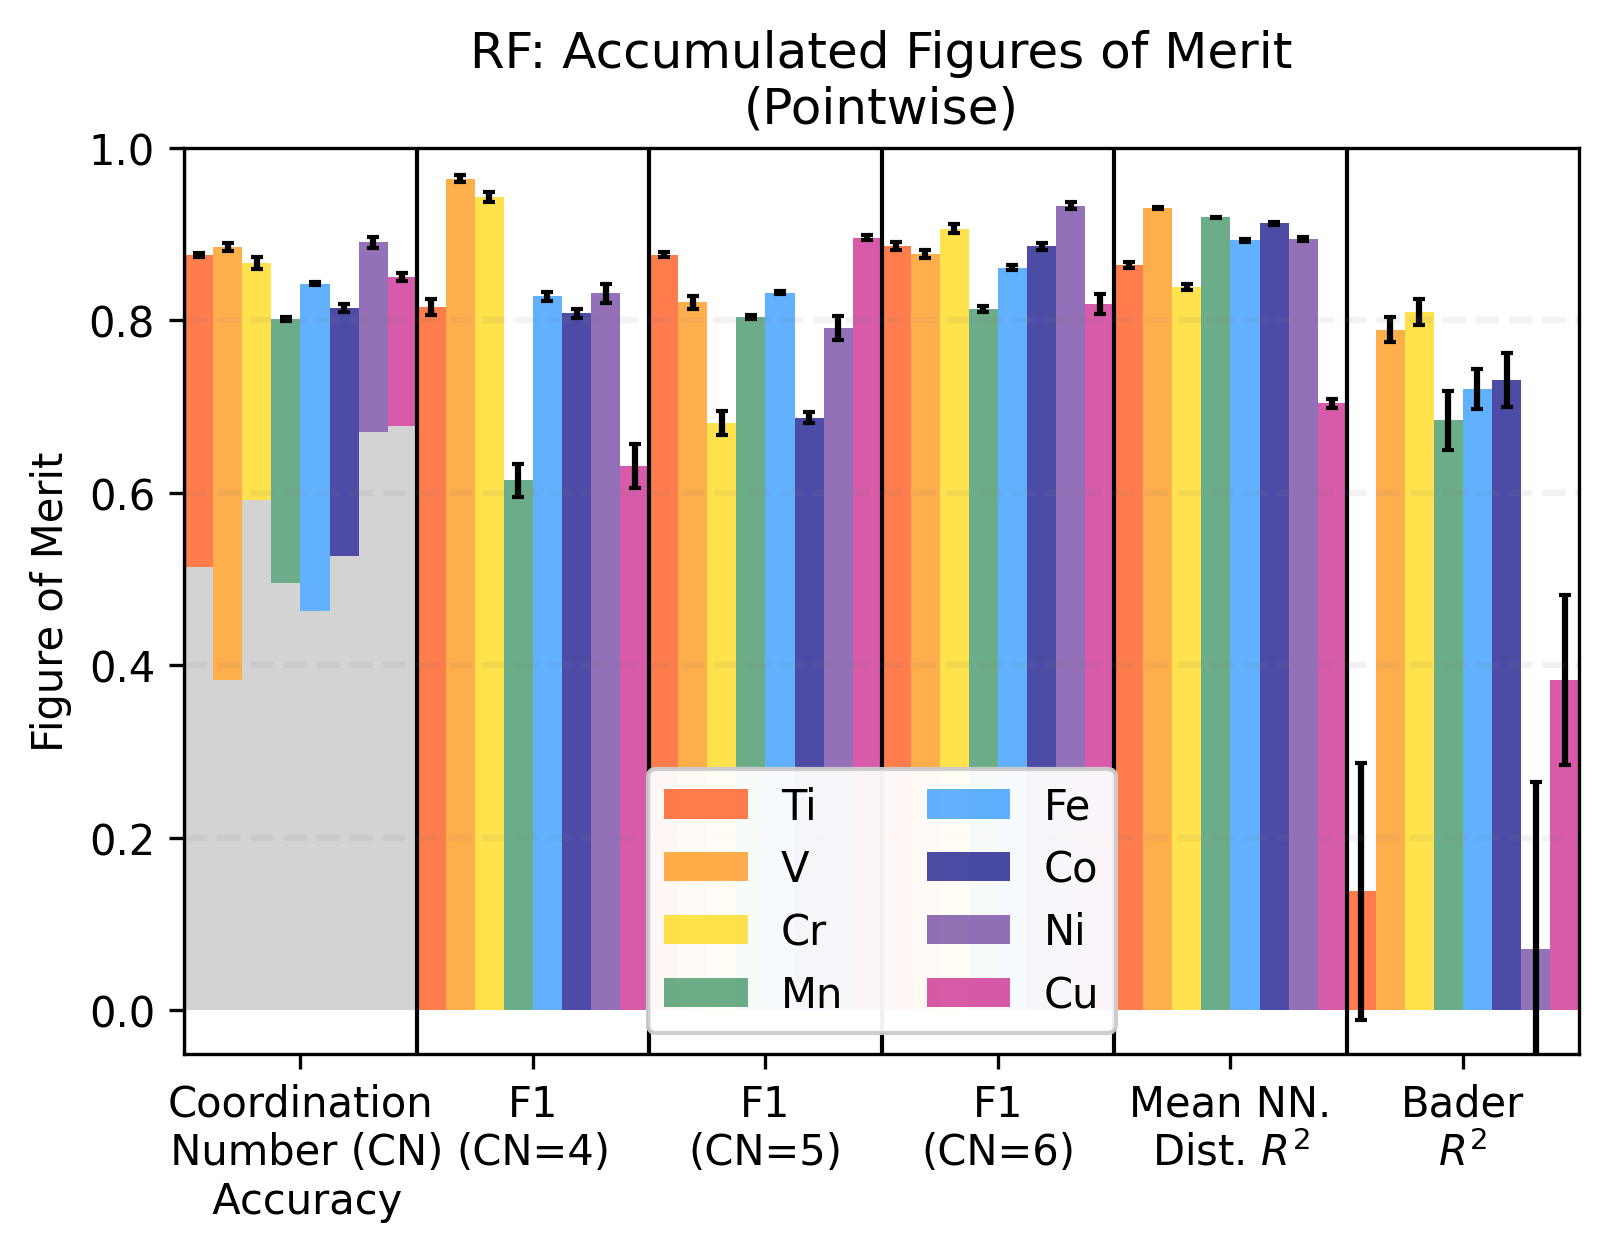

In [17]:
plt.clf()
plt.figure(dpi=300)
for pj, pair in enumerate(target_elements_groups):
    
    
    plt.bar(pj+.5,accuracies[str(pair)+'-Coord']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           label=str(pair[0]),
           yerr = deviations[str(pair)+'-Coord']/100,capsize=1.5)
    plt.bar(pj+.5,accuracies[str(pair)+'-GuessMode']/100,color='lightgrey',width=1,alpha=1)
    plt.bar(pj+.5+8,accuracies[str(pair)+'-Coord-F1'][0]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations[str(pair)+'-Coord-F1'][0]/100, capsize=1.5)
    
    plt.bar(pj+.5+2*8,accuracies[str(pair)+'-Coord-F1'][1]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations[str(pair)+'-Coord-F1'][1]/100,capsize=1.5)
    
    plt.bar(pj+.5+3*8,accuracies[str(pair)+'-Coord-F1'][2]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations[str(pair)+'-Coord-F1'][2]/100,capsize=1.5)
    
    plt.bar(pj+.5+4*8,accuracies[str(pair)+'-MeanDist']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr =  deviations[str(pair)+'-MeanDist']/100,capsize=1.5)
    
    plt.bar(pj+.5+5*8,accuracies[str(pair)+'-Bader']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr =  deviations[str(pair)+'-Bader']/100,capsize=1.5)
    
    
for i in [0,8,16,24,32,40]:
    plt.axvline(i,color='black',lw=1,ls='-')

for i in [.2,.4,.6,.8]:
    plt.axhline(i,color='gray',ls='--',alpha=.1)

plt.xticks([8*i+4  for i in range(0,6)],
                labels=['Coordination\n Number (CN)\n Accuracy', 'F1\n(CN=4)', 'F1\n(CN=5)', 'F1\n(CN=6)',
                                      'Mean NN.\nDist. $R^2$','Bader\n$R^2$'],)
plt.xticks()
plt.xlim(0,6*7+6)
plt.ylim(-0.05,1.0000001)
plt.ylabel('Figure of Merit')


plt.title("RF: Accumulated Figures of Merit\n(Pointwise)")

plt.legend(loc='lower center',ncol=2,framealpha=.95)
plt.savefig(f'{figure_write_folder}/{norm_str}_all_perf.svg',format='svg',dpi=300,bbox_inches='tight',transprent=True)

In [18]:
### Convolutional Neural Networks

<Figure size 432x288 with 0 Axes>

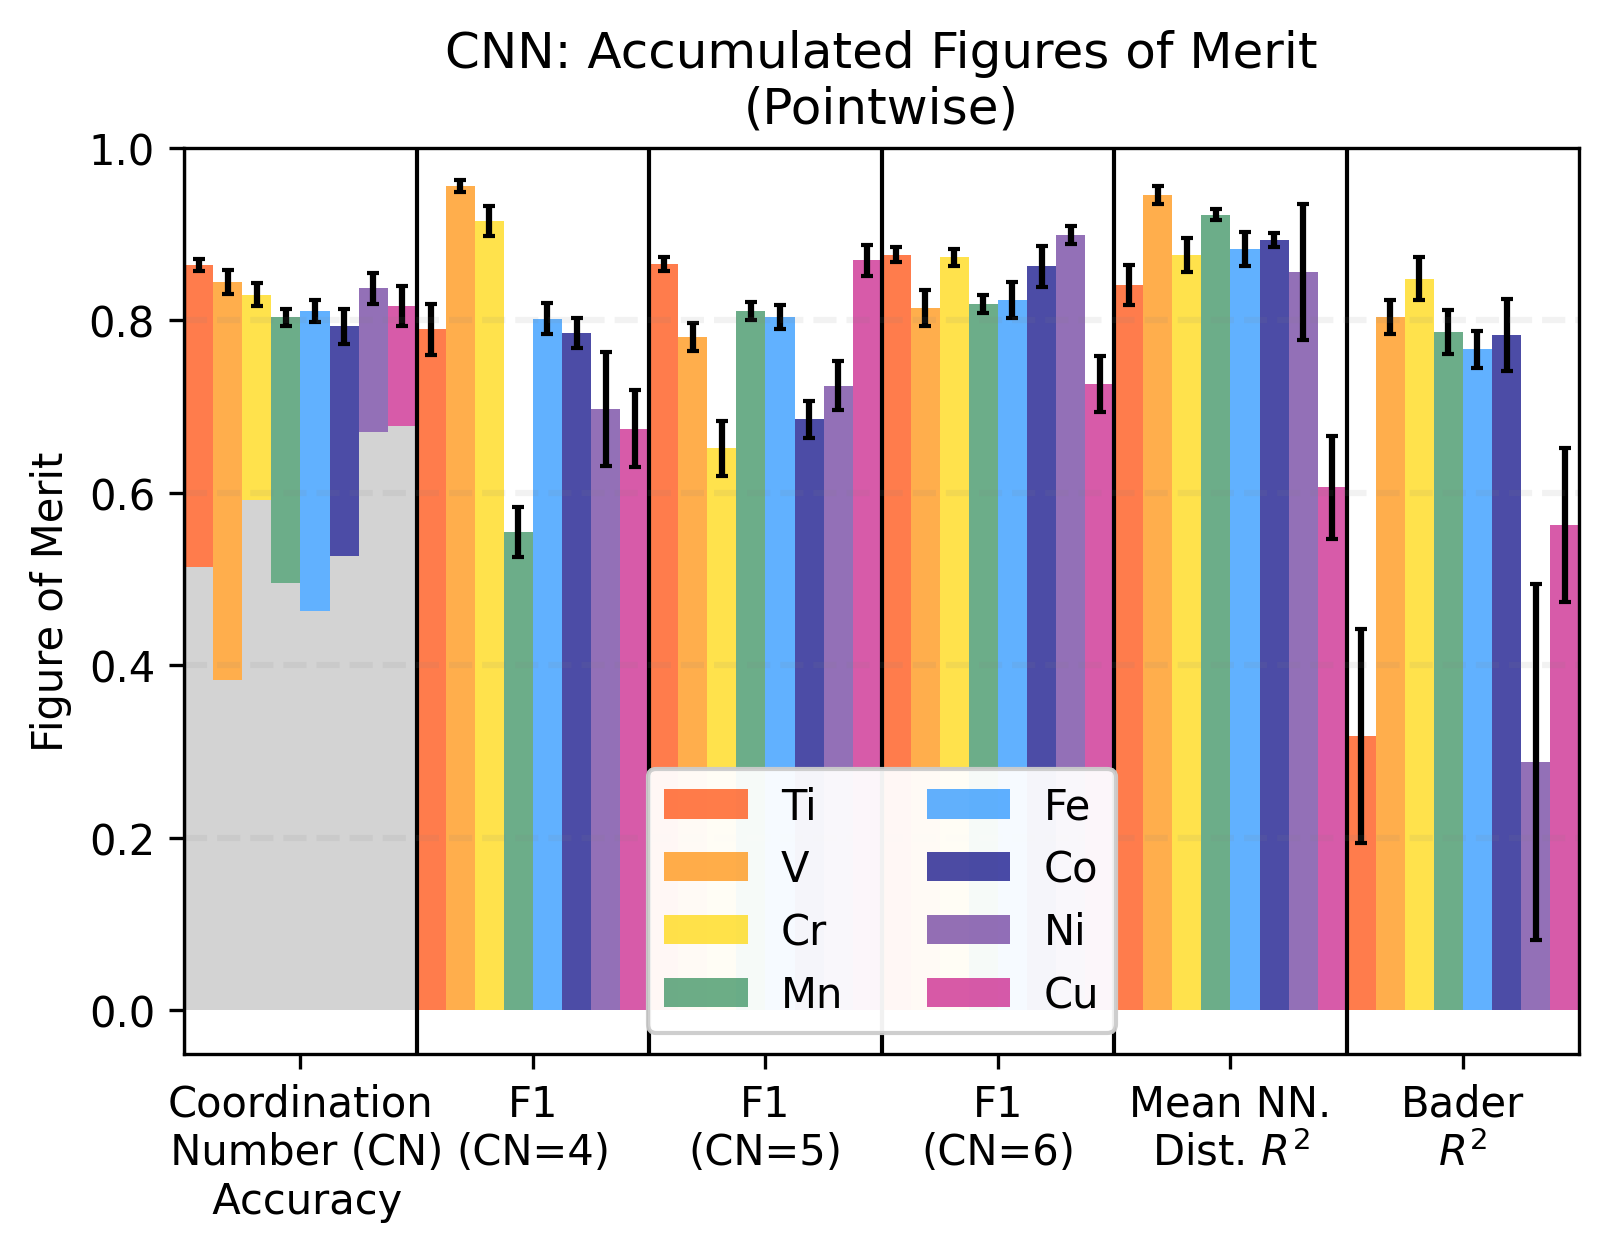

In [19]:
plt.clf()
plt.figure(dpi=300)
for pj, pair in enumerate(target_elements_groups):
    
    
    
    plt.bar(pj+.5,accuracies_nn[str(pair)+'-Coord']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           label=str(pair[0]),
           yerr = deviations_nn[str(pair)+'-Coord']/100,capsize=1.5)
    plt.bar(pj+.5,accuracies_nn[str(pair)+'-GuessMode']/100,color='lightgrey',width=1,alpha=1)
    plt.bar(pj+.5+8,accuracies_nn[str(pair)+'-Coord-F1'][0]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations_nn[str(pair)+'-Coord-F1'][0]/100, capsize=1.5)
    
    plt.bar(pj+.5+2*8,accuracies_nn[str(pair)+'-Coord-F1'][1]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations_nn[str(pair)+'-Coord-F1'][1]/100,capsize=1.5)
    
    plt.bar(pj+.5+3*8,accuracies_nn[str(pair)+'-Coord-F1'][2]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations_nn[str(pair)+'-Coord-F1'][2]/100,capsize=1.5)
    
    plt.bar(pj+.5+4*8,accuracies_nn[str(pair)+'-MeanDist']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr =  deviations_nn[str(pair)+'-MeanDist']/100,capsize=1.5)
    
    plt.bar(pj+.5+5*8,accuracies_nn[str(pair)+'-Bader']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr =  deviations_nn[str(pair)+'-Bader']/100,capsize=1.5)
    
    
    
    
for i in [0,8,16,24,32,40]:
    plt.axvline(i,color='black',lw=1,ls='-')

for i in [.2,.4,.6,.8]:
    plt.axhline(i,color='gray',ls='--',alpha=.1)

plt.xticks([8*i+4  for i in range(0,6)],
                labels=['Coordination\n Number (CN)\n Accuracy', 'F1\n(CN=4)', 'F1\n(CN=5)', 'F1\n(CN=6)',
                                      'Mean NN.\nDist. $R^2$','Bader\n$R^2$'],)
plt.xticks()
plt.xlim(-0,6*7+6)
plt.ylim(-0.05,1.0000001)
plt.ylabel('Figure of Merit')


plt.title("CNN: Accumulated Figures of Merit\n(Pointwise)")

plt.legend(loc='lower center',ncol=2,framealpha=.95)
plt.savefig(f'{figure_write_folder}/{norm_str}_all_perf_nn.svg',format='svg',dpi=300,bbox_inches='tight',transprent=True)

# Performance of MD Fitting- Uniparity
### Random Forest

<Figure size 432x288 with 0 Axes>

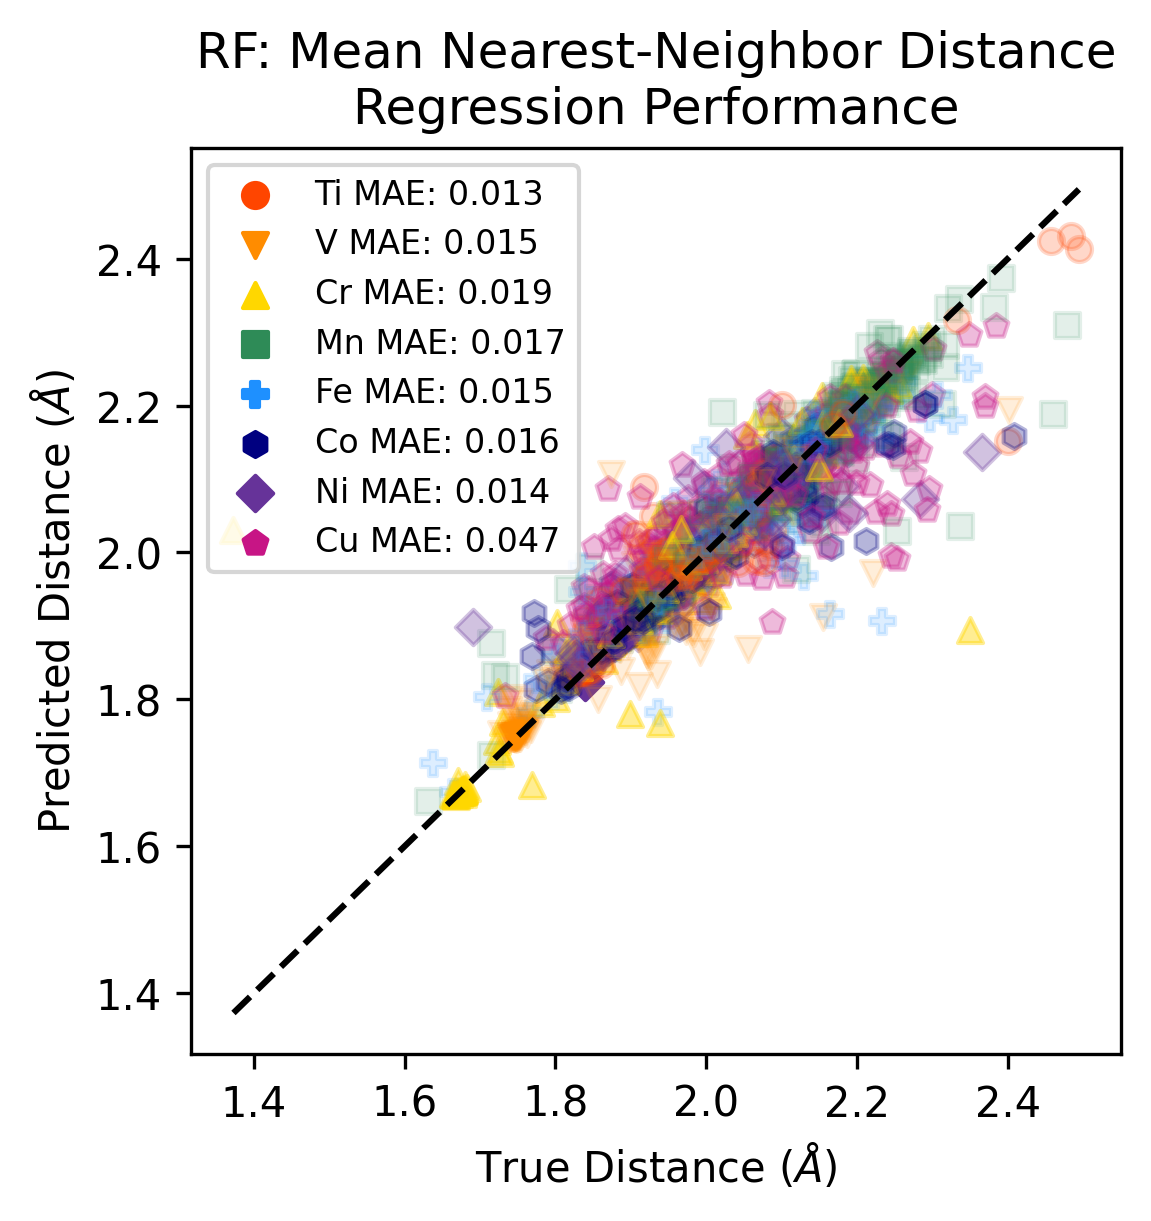

In [20]:

pair_to_icon={'Ti':"o",
              'V':'v',
              'Cr':'^',
              'Mn':"s",
              'Fe':"P",
              'Co':"h",
             'Ni':'D',
              'Cu':'p'}
all_min = 100
all_max = 0
plt.clf()
plt.figure(figsize=(4,4),dpi=300)
for pair in target_elements_groups:
    number = len(md_perf_by_pair[pair[0]+'-guesses'])
    all_min = min(all_min, min(md_perf_by_pair[pair[0]+'-labels']),min(md_perf_by_pair[pair[0]+'-guesses']))
    all_max = max(all_max, max(md_perf_by_pair[pair[0]+'-labels']),max(md_perf_by_pair[pair[0]+'-guesses']))

    plt.scatter(md_perf_by_pair[pair[0]+'-labels'][0],
                    md_perf_by_pair[pair[0]+'-guesses'][0],
                    zorder=-1,
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 1,
                    label = pair[0] + " MAE: " +str(np.round((accuracies[str(pair)+'-MeanDist-MAE']),3)))
    #print(number, len(md_perf_by_pair[pair[0]+'-labels']))
    for i in range(number)[1:]:
        plt.scatter(md_perf_by_pair[pair[0]+'-labels'][i],
                    md_perf_by_pair[pair[0]+'-guesses'][i],
                    zorder=np.random.uniform(0,1),
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 100/number)

plt.plot((all_min,all_max),(all_min,all_max),color='black',ls='--')
plt.legend(fontsize=8)
plt.title("RF: Mean Nearest-Neighbor Distance\nRegression Performance")
plt.xlabel("True Distance ($\AA$)")
plt.ylabel("Predicted Distance ($\AA$)")

plt.savefig(f'{figure_write_folder}/{norm_str}_md_uniparity.svg',format='svg',dpi=300,bbox_inches='tight')

plt.show()

### Convolutional Neural Networks

<Figure size 432x288 with 0 Axes>

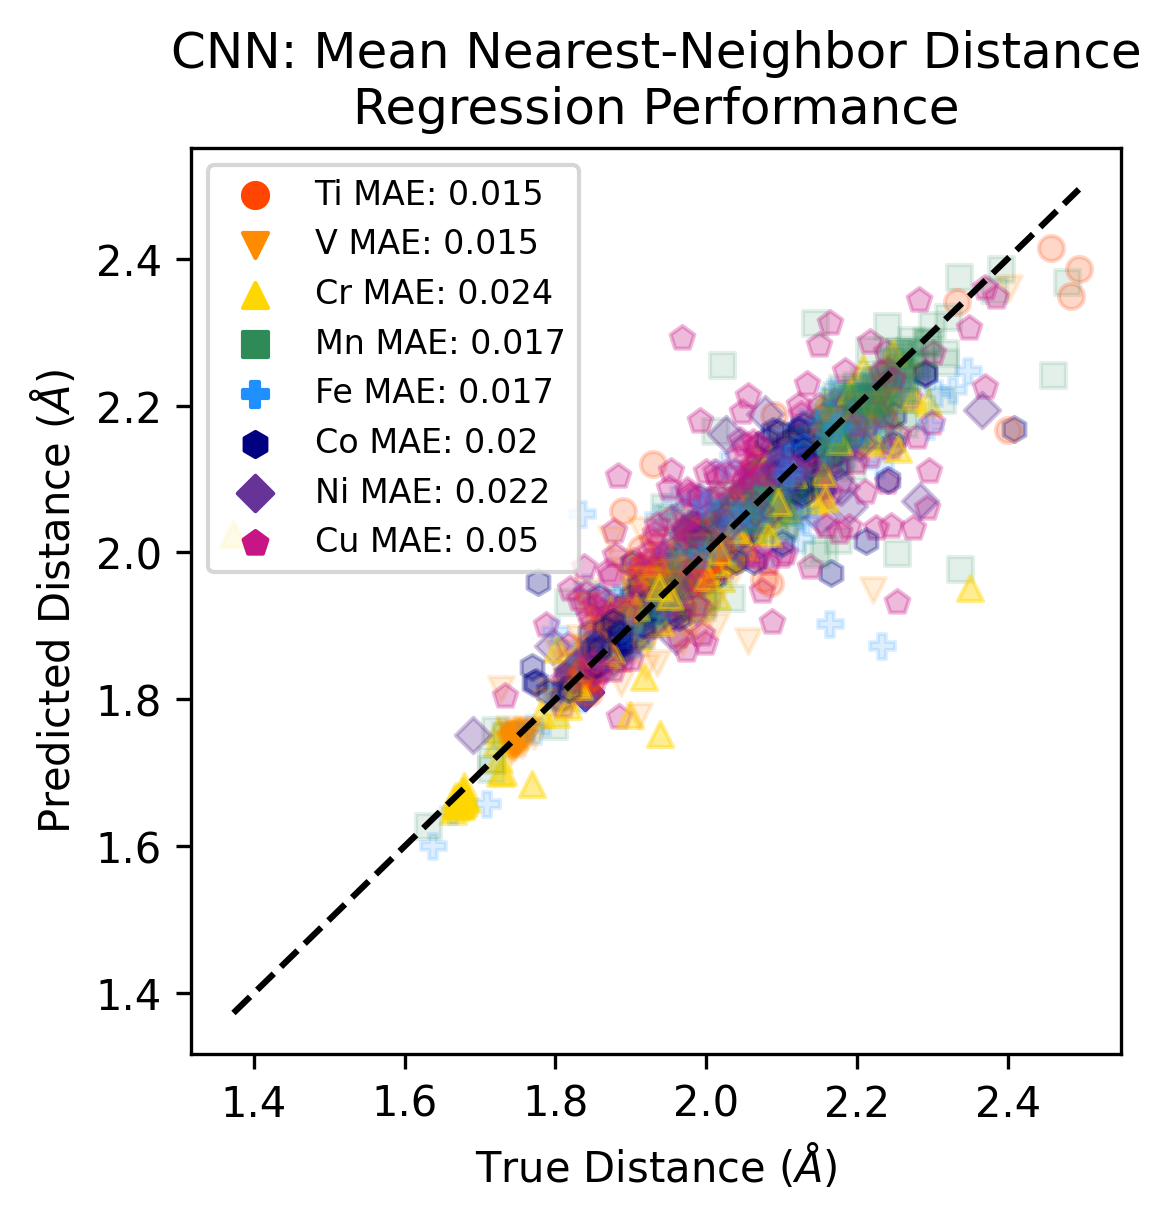

In [21]:
pair_to_icon={'Ti':"o",
              'V':'v',
              'Cr':'^',
              'Mn':"s",
              'Fe':"P",
              'Co':"h",
             'Ni':'D',
              'Cu':'p'}
all_min = 100
all_max = 0
plt.clf()
plt.figure(figsize=(4,4),dpi=300)
for pair in target_elements_groups:
    number = len(md_perf_by_pair_nn[pair[0]+'-guesses'])
    all_min = min(all_min, min(md_perf_by_pair[pair[0]+'-labels']),min(md_perf_by_pair_nn[pair[0]+'-guesses']))
    all_max = max(all_max, max(md_perf_by_pair[pair[0]+'-labels']),max(md_perf_by_pair_nn[pair[0]+'-guesses']))

    plt.scatter(md_perf_by_pair[pair[0]+'-labels'][0],
                    md_perf_by_pair_nn[pair[0]+'-guesses'][0],
                    zorder=-1,
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 1,
                    label = pair[0] + " MAE: " +str(np.round((accuracies_nn[str(pair)+'-MeanDist-MAE']),3)))
    #print(number, len(md_perf_by_pair[pair[0]+'-labels']))
    for i in range(number)[1:]:
        plt.scatter(md_perf_by_pair[pair[0]+'-labels'][i],
                    md_perf_by_pair_nn[pair[0]+'-guesses'][i],
                    zorder=np.random.uniform(0,1),
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 100/number)

plt.plot((all_min,all_max),(all_min,all_max),color='black',ls='--')
plt.legend(fontsize=8)
plt.title("CNN: Mean Nearest-Neighbor Distance\nRegression Performance")
plt.xlabel("True Distance ($\AA$)")
plt.ylabel("Predicted Distance ($\AA$)")

plt.savefig(f'{figure_write_folder}/{norm_str}_md_uniparity_nn.svg',format='svg',dpi=300,bbox_inches='tight')

plt.show()

## Bader Performance
### Random Forest

<Figure size 432x288 with 0 Axes>

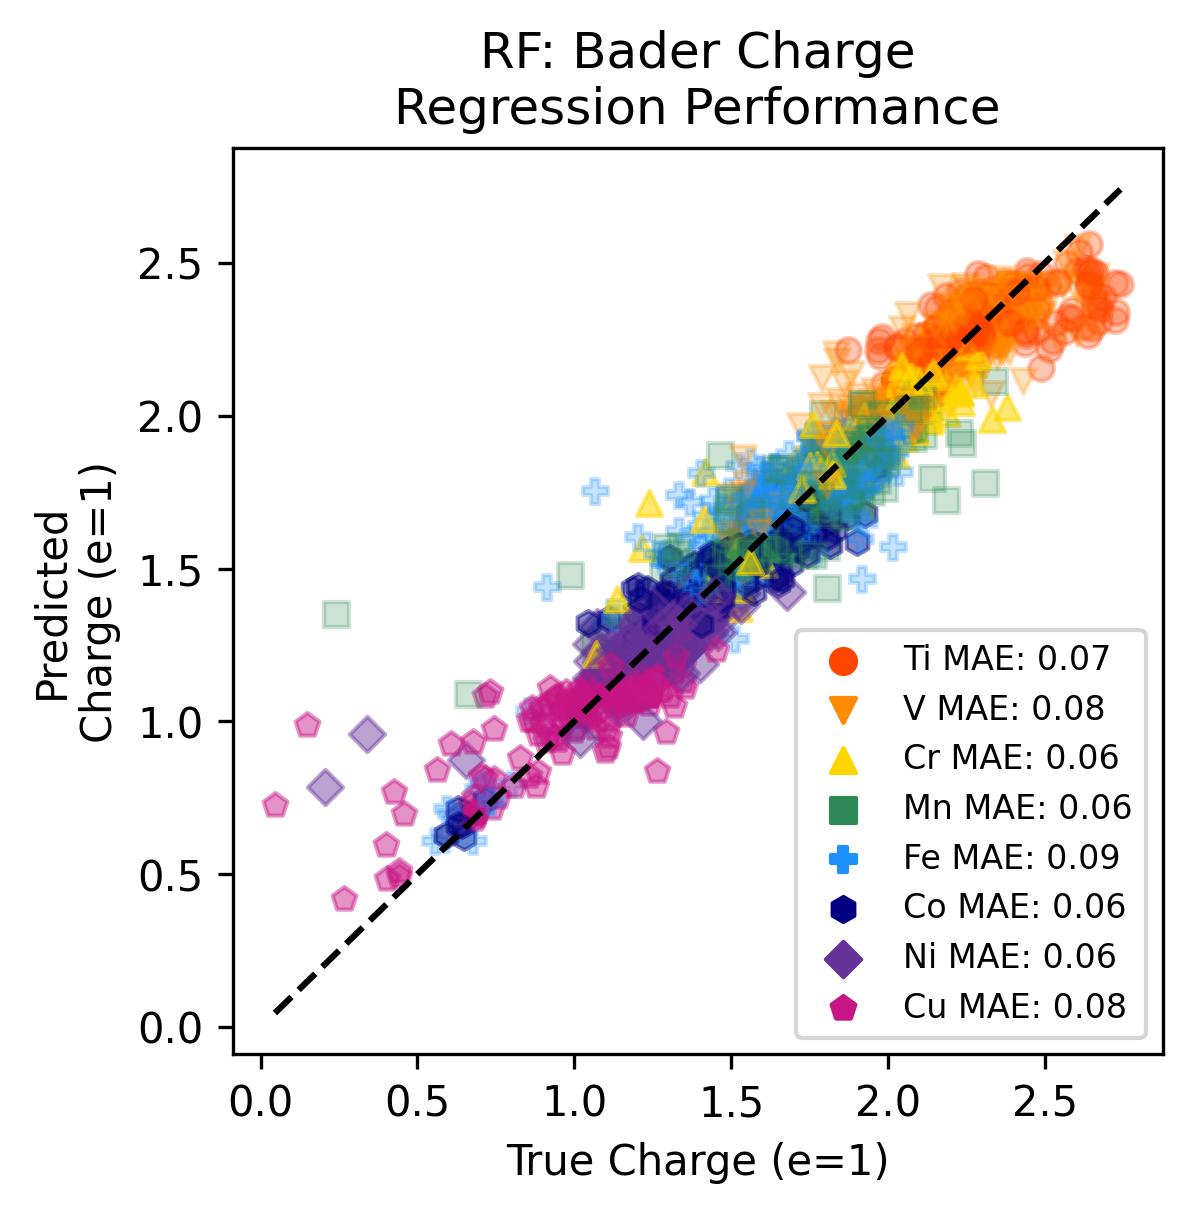

In [22]:

pair_to_icon={'Ti':"o",
              'V':'v',
              'Cr':'^',
              'Mn':"s",
              'Fe':"P",
              'Co':"h",
             'Ni':'D',
              'Cu':'p'}
all_min = 100
all_max = 0
plt.clf()
plt.figure(figsize=(4,4),dpi=300)
for pair in target_elements_groups:
    number = len(bader_perf_by_pair[pair[0]+'-guesses'])
    all_min = min(all_min, min(bader_perf_by_pair[pair[0]+'-labels']),min(bader_perf_by_pair[pair[0]+'-guesses']))
    all_max = max(all_max, max(bader_perf_by_pair[pair[0]+'-labels']),max(bader_perf_by_pair[pair[0]+'-guesses']))

    plt.scatter(bader_perf_by_pair[pair[0]+'-labels'][0],
                bader_perf_by_pair[pair[0]+'-guesses'][0],
                zorder=-1,
                marker=pair_to_icon[pair[0]],
                color= colors_by_pair[pair], 
                alpha = 1,
                label=pair[0]+" MAE: "
                +str(np.round(accuracies[str(pair)+'-Bader-MAE'],2))) 
                #+f"\t R$^2$:{accuracies[str(pair)+'-Bader']:.2f}") 
    #print(number, len(md_perf_by_pair[pair[0]+'-labels']))
    for i in range(number)[1:]:
        plt.scatter(bader_perf_by_pair[pair[0]+'-labels'][i],
                    bader_perf_by_pair[pair[0]+'-guesses'][i],
                    zorder=np.random.uniform(0,1),
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 100/number)

plt.plot((all_min,all_max),(all_min,all_max),color='black',ls='--')
plt.legend(fontsize=8,loc='best')
plt.title("RF: Bader Charge\nRegression Performance")
plt.xlabel("True Charge (e=1)")
plt.ylabel("Predicted\nCharge (e=1)")
plt.savefig(f'{figure_write_folder}/{norm_str}_bader_uniparity.svg',format='svg',dpi=300,bbox_inches='tight')

plt.show()

### Convolutional Neural Networks

<Figure size 432x288 with 0 Axes>

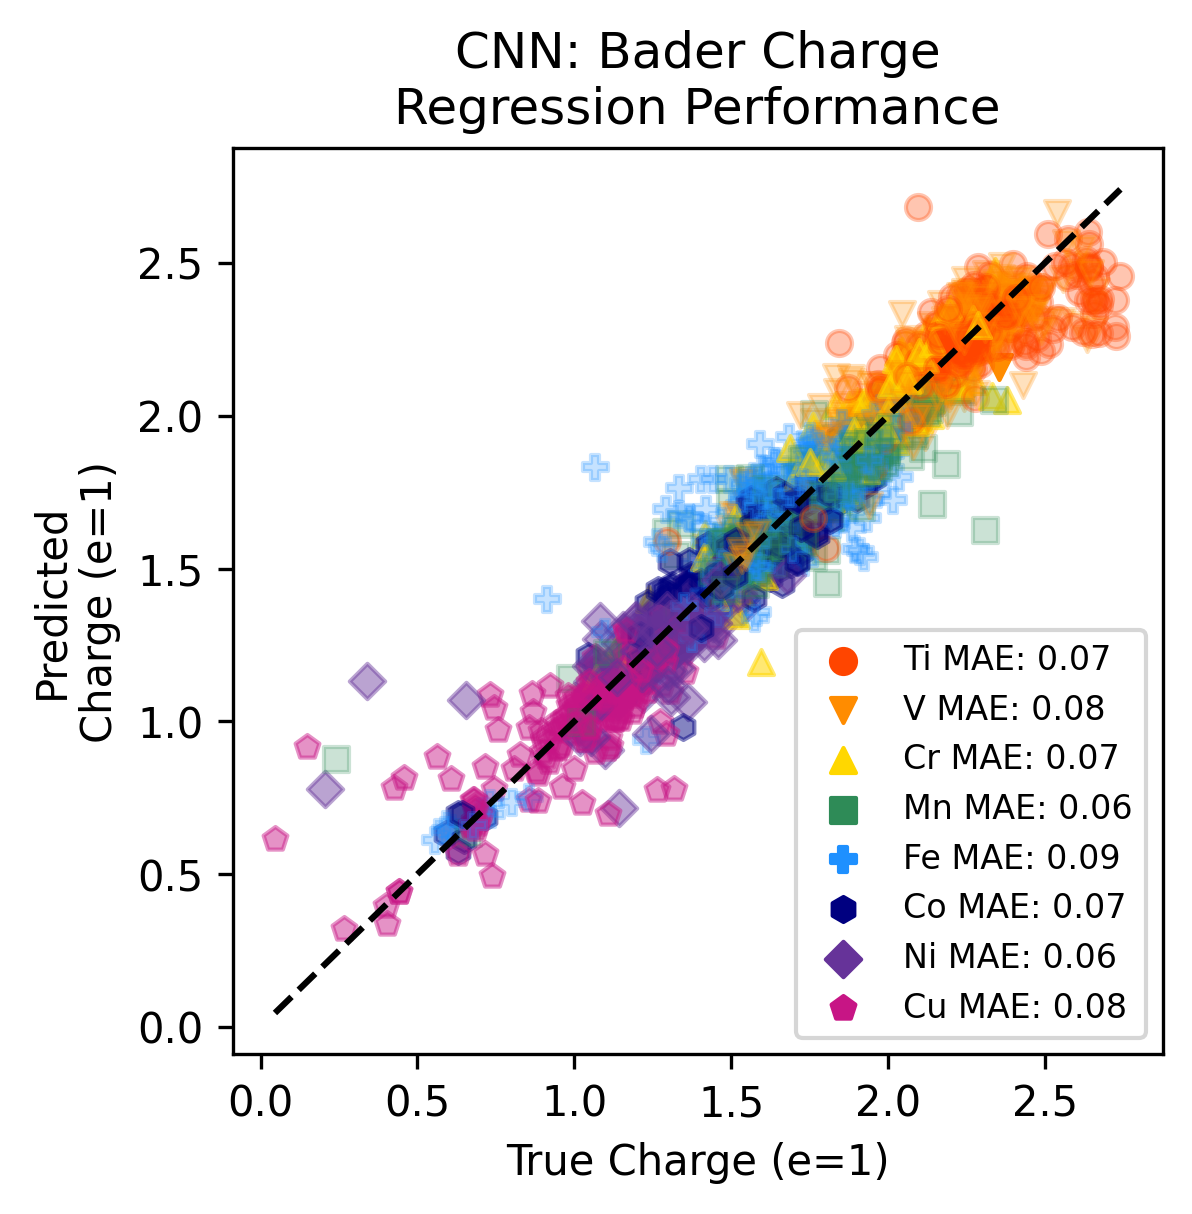

In [23]:
pair_to_icon={'Ti':"o",
              'V':'v',
              'Cr':'^',
              'Mn':"s",
              'Fe':"P",
              'Co':"h",
             'Ni':'D',
              'Cu':'p'}
all_min = 100
all_max = 0
plt.clf()
plt.figure(figsize=(4,4),dpi=300)
for pair in target_elements_groups:
    number = len(bader_perf_by_pair_nn[pair[0]+'-guesses'])
    all_min = min(all_min, min(bader_perf_by_pair_nn[pair[0]+'-labels']),min(bader_perf_by_pair_nn[pair[0]+'-guesses']))
    all_max = max(all_max, max(bader_perf_by_pair_nn[pair[0]+'-labels']),max(bader_perf_by_pair_nn[pair[0]+'-guesses']))

    plt.scatter(bader_perf_by_pair_nn[pair[0]+'-labels'][0],
                bader_perf_by_pair_nn[pair[0]+'-guesses'][0],
                zorder=-1,
                marker=pair_to_icon[pair[0]],
                color= colors_by_pair[pair], 
                alpha = 1,
                label=pair[0]+" MAE: "
                +str(np.round(accuracies_nn[str(pair)+'-Bader-MAE'],2))) 
                #+f"\t R$^2$:{accuracies[str(pair)+'-Bader']:.2f}") 
    #print(number, len(md_perf_by_pair[pair[0]+'-labels']))
    for i in range(number)[1:]:
        plt.scatter(bader_perf_by_pair_nn[pair[0]+'-labels'][i],
                    bader_perf_by_pair_nn[pair[0]+'-guesses'][i],
                    zorder=np.random.uniform(0,1),
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 100/number)

plt.plot((all_min,all_max),(all_min,all_max),color='black',ls='--')
plt.legend(fontsize=8,loc='best')
plt.title("CNN: Bader Charge\nRegression Performance")
plt.xlabel("True Charge (e=1)")
plt.ylabel("Predicted\nCharge (e=1)")
plt.savefig(f'{figure_write_folder}/{norm_str}_bader_uniparity_nn.svg',format='svg',dpi=300,bbox_inches='tight')

plt.show()

## --------------

#                     PART TWO: POLYNOMIALS

## Load in the Polynomial Fit Data

# The Big Cell - Polynomialized Data

# Polynomial Performance Table

--------------
# Part 3: Plotting Comparative Performance of Training & Testing, and Feature Importance


###  Feature Rank Function Definition

# Plot Change in Performance from Pointwise to Polynomial